# Flatiron Health aNSCLC: Strict trials with GBM crude 

***OBJECTIVE:*** **Inclusion criteria for trials in other notebooks were relaxed to allow for as many patients to be included as reasonably possible. In this notebook, inclusion criteria for the trials will be followed as closely as possible. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 
** 

***OUTLINE:***
1. **Identify patients with exclusion criteria:**
* Autoimmune diseases in the year preceding metastatic diagnosis  
* Other relevant comorbidities in the year preceding metastatic diagnosis  
* CNS metastasis at start of treatment 
* ECOG 2, 3, or 4 at start of treatment 
* Organ dysfunction at time of treatment 

2. **In silico trials:**
* KEYNOTE-042 
* KEYNOTE-024
* KEYNOTE-189 
* CHECKMATE-078
* FLAURA

## Part 1: Identify patients with exclusion criteria

In [1]:
import numpy as np
import pandas as pd

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

In [3]:
train = pd.read_csv('train_full.csv')
row_ID(train)

(54786, 54786)

In [4]:
test = pd.read_csv('test_full.csv')
row_ID(test)

(13697, 13697)

In [5]:
df = pd.concat([train, test], ignore_index = True)
row_ID(df)

(68483, 68483)

### 1. Autoimmune diseases in the year preceding advanced diagnosis 
* Type 1 diabetes
* Rheumatoid arthritis
* Lupus
* Systemic sclerosis 
* Dermatomyositis
* Polymyositis
* Crohn's disease
* Ulcerative colitis 
* Psoriasis 
* Multiple sclerosis 

In [6]:
diagnosis = pd.read_csv('Diagnosis.csv')

In [7]:
diagnosis = diagnosis[diagnosis['PatientID'].isin(df['PatientID'])]       

In [8]:
diagnosis.loc[:, 'DiagnosisDate'] = pd.to_datetime(diagnosis['DiagnosisDate'])

In [9]:
enhanced_adv = pd.read_csv('Enhanced_AdvancedNSCLC.csv', low_memory = False)

In [10]:
enhanced_adv.loc[:, 'AdvancedDiagnosisDate'] = pd.to_datetime(enhanced_adv['AdvancedDiagnosisDate'])

In [11]:
row_ID(diagnosis)

(1499292, 68483)

In [12]:
diagnosis = pd.merge(diagnosis, enhanced_adv[['PatientID', 'AdvancedDiagnosisDate']], on = 'PatientID', how = 'left')

In [13]:
row_ID(diagnosis)

(1499292, 68483)

In [14]:
diagnosis.loc[:, 'date_diff'] = (diagnosis['DiagnosisDate'] - diagnosis['AdvancedDiagnosisDate']).dt.days

In [15]:
diagnosis.loc[:, 'diagnosis_code'] = diagnosis['DiagnosisCode'].replace('\.', '', regex = True)

In [16]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_9 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [17]:
auto_ID_9 = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('250(0[13]|1[13]|2[13]|3[13]|4[13]|5[13]|6[13]|7[13]|8[13]|9[13])|'
                                                        '714|'
                                                        '710[0134]|'
                                                        '55[56]|'
                                                        '696|'
                                                        '340')].PatientID.unique())

In [18]:
len(auto_ID_9)

87

In [19]:
# ICD-9 dataframe with unique codes for each patient. 
diagnosis_10 = (
    diagnosis
    .query('date_diff <= 0 and date_diff > -365')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [20]:
auto_ID_10 = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('E10|'
                                                          'M05|'
                                                          'M32|'
                                                          'M33|'
                                                          'M34|'
                                                          'K50|'
                                                          'K51|'
                                                          'L40|'
                                                          'G35')].PatientID.unique())

In [21]:
len(auto_ID_10)

238

In [22]:
auto_IDs = np.unique(np.concatenate([auto_ID_9, auto_ID_10]))

In [23]:
len(auto_IDs)

322

### 2. Other relevant comorbidities in the year preceding advanced diagnosis 
* Interstitial lung disease 
* HIV
* Hep C
* Hep B
* Psychosis and other significant psychiatric disorders 
* Drug use disorders

In [24]:
other_comorb_9 = (
    diagnosis_9[diagnosis_9['diagnosis_code'].str.match('516|'
                                                        '042|'
                                                        '070[234567]|'
                                                        '29[5789]|'
                                                        '30[34]')].PatientID.unique())

In [25]:
len(other_comorb_9)

69

In [26]:
other_comorb_10 = (
    diagnosis_10[diagnosis_10['diagnosis_code'].str.match('J84|'
                                                          'B20|'
                                                          'B18|'
                                                          'F2[024589]|'
                                                          'F1[0145]')].PatientID.unique())

In [27]:
len(other_comorb_10)

474

In [28]:
other_comorb_IDs = np.unique(np.concatenate([other_comorb_9, other_comorb_10]))

In [29]:
len(other_comorb_IDs)

537

### 3. CNS metastasis at start of treatment 

#### First line treatment

In [30]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [31]:
line_therapy = line_therapy[line_therapy['PatientID'].isin(df['PatientID'])]       

In [32]:
line_therapy.loc[:, 'StartDate'] = pd.to_datetime(line_therapy['StartDate'])

In [33]:
therapy_fl = line_therapy.query('LineNumber == 1').query('IsMaintenanceTherapy == False')[['PatientID', 'StartDate']]

In [34]:
row_ID(diagnosis)

(1499292, 68483)

In [35]:
cns_fl = pd.merge(diagnosis, therapy_fl, on = 'PatientID', how = 'left')

In [36]:
row_ID(diagnosis)

(1499292, 68483)

In [37]:
cns_fl.loc[:, 'fl_date_diff'] = (cns_fl['DiagnosisDate'] - cns_fl['StartDate']).dt.days

In [38]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_9 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [39]:
cns_fl_9_ids = (
    cns_fl_9[cns_fl_9['diagnosis_code'].str.match('198[34]')].PatientID.unique()
)

In [40]:
len(cns_fl_9_ids)

1065

In [41]:
# ICD-9 dataframe with unique codes for each patient. 
cns_fl_10 = (
    cns_fl
    .query('fl_date_diff <= 0 and fl_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [42]:
cns_fl_10_ids = (
    cns_fl_10[cns_fl_10['diagnosis_code'].str.match('C79[34]')].PatientID.unique()
)

In [43]:
len(cns_fl_10_ids)

2829

In [44]:
cns_fl_IDs = np.unique(np.concatenate([cns_fl_9_ids, cns_fl_10_ids]))

In [45]:
len(cns_fl_IDs)

3876

#### Second line treatment

In [46]:
therapy_sec = line_therapy.query('LineNumber == 2')[['PatientID', 'StartDate']]

In [47]:
row_ID(diagnosis)

(1499292, 68483)

In [48]:
cns_sec = pd.merge(diagnosis, therapy_sec, on = 'PatientID', how = 'left')

In [49]:
row_ID(diagnosis)

(1499292, 68483)

In [50]:
cns_sec.loc[:, 'sec_date_diff'] = (cns_sec['DiagnosisDate'] - cns_sec['StartDate']).dt.days

In [51]:
# ICD-9 dataframe with unique codes for each patient. 
cns_sec_9 = (
    cns_sec
    .query('sec_date_diff <= 0 and sec_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-9-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [52]:
cns_sec_9_ids = (
    cns_sec_9[cns_sec_9['diagnosis_code'].str.match('198[34]')].PatientID.unique()
)

In [53]:
len(cns_sec_9_ids)

252

In [54]:
# ICD-9 dataframe with unique codes for each patient. 
cns_sec_10 = (
    cns_sec
    .query('sec_date_diff <= 0 and sec_date_diff > -90')
    .query('DiagnosisCodeSystem == "ICD-10-CM"')
    .drop_duplicates(subset = (['PatientID', 'DiagnosisCode']), keep = 'first')
    .filter(items = ['PatientID', 'DiagnosisCode', 'diagnosis_code'])
)

In [55]:
cns_sec_10_ids = (
    cns_sec_10[cns_sec_10['diagnosis_code'].str.match('C79[34]')].PatientID.unique()
)

In [56]:
len(cns_sec_10_ids)

765

In [57]:
cns_sec_IDs = np.unique(np.concatenate([cns_sec_9_ids, cns_sec_10_ids]))

In [58]:
len(cns_sec_IDs)

1000

### 4. ECOG >1 at start of treatment 

In [59]:
base_ecog = pd.read_csv('BaselineECOG.csv')

In [60]:
base_ecog = base_ecog[base_ecog['PatientID'].isin(df['PatientID'])]       

In [61]:
ecog_fl_IDs = (
    base_ecog
    .query('LineNumber == 1')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [62]:
len(ecog_fl_IDs)

8927

In [63]:
ecog_sec_IDs = (
    base_ecog
    .query('LineNumber == 2')
    .query('ECOGValue == "2" or ECOGValue == "3" or ECOGValue == "4"')
    .PatientID.unique())

In [64]:
len(ecog_sec_IDs)

4022

### 5. Abnormal organ function at start of treatment 
* Hemoglobin >9
* Creatinine <2
* Total bilirubin <3

In [65]:
lab = pd.read_csv('Lab.csv')

In [66]:
lab = lab[lab['PatientID'].isin(df['PatientID'])]

In [67]:
lab.loc[:, 'ResultDate'] = pd.to_datetime(lab['ResultDate'], errors = 'coerce') 

In [68]:
row_ID(lab)

(39492037, 64852)

In [69]:
lab = pd.merge(lab, therapy_fl[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [70]:
row_ID(lab)

(39492037, 64852)

In [71]:
# Select rows with clinically relevant labs.
lab_core = (
    lab[
    (lab['LOINC'] == "2160-0") |
    (lab['LOINC'] == "38483-4") | 
    (lab['LOINC'] == "718-7") |
    (lab['LOINC'] == "20509-6") |
    (lab['LOINC'] == "42719-5") |
    (lab['LOINC'] == "1975-2")]
    .filter(items = ['PatientID', 
                     'ResultDate', 
                     'LOINC', 
                     'LabComponent', 
                     'TestUnits', 
                     'TestUnitsCleaned', 
                     'TestResult', 
                     'TestResultCleaned', 
                     'StartDate'])
)

In [72]:
conditions = [
    ((lab_core['LOINC'] == '2160-0') | (lab_core['LOINC'] == '38483-4')),
    ((lab_core['LOINC'] == '718-7') | (lab_core['LOINC'] == '20509-6')),
    ((lab_core['LOINC'] == '42719-5') | (lab_core['LOINC'] == '1975-2'))]

choices = ['creatinine', 
           'hemoglobin', 
           'total_bilirubin']

lab_core.loc[:, 'lab_name'] = np.select(conditions, choices)

In [73]:
row_ID(lab_core)

(3835679, 64616)

In [74]:
conditions = [
    (lab_core['lab_name'] == 'hemoglobin') & (lab_core['TestUnits'] == 'g/uL')]

choices = [lab_core['TestResultCleaned'] / 100000]

lab_core.loc[:, 'test_result_cleaned'] = np.select(conditions, choices, default = lab_core['TestResultCleaned'])

In [75]:
lab_f = (
    lab_core
    .assign(lab_date_diff = (lab_core['ResultDate'] - lab_core['StartDate']).dt.days)
    .query('lab_date_diff <= 0 and lab_date_diff > -90')
    .sort_values(by = ['PatientID', 'lab_name', 'lab_date_diff'], ascending = [True, True, False])
    .drop_duplicates(subset = ['PatientID', 'lab_name'], keep = 'first' )
)

In [76]:
# Select lab closest to date of advanced diagnosis and pivot to a wide table. 
lab_wide = (
    lab_f
    .pivot(index = 'PatientID', columns = 'lab_name', values = 'test_result_cleaned')
    .reset_index())

lab_wide.columns.name = None

In [77]:
lab_wide.sample(3)

,PatientID,creatinine,hemoglobin,total_bilirubin
16474,F5C3EC70ED685,0.46,9.40,0.2
27744,F9B4FCEE312E9,0.76,13.68,0.4
36142,FCA26FEC49B24,0.85,11.30,0.3


In [78]:
ab_organ_IDs = lab_wide.query('creatinine > 2 or hemoglobin < 9 or total_bilirubin > 3').PatientID

In [79]:
len(ab_organ_IDs)

2256

In [80]:
ab_organ_IDs.to_csv('ab_organ_IDs.csv', index = False)

In [81]:
del diagnosis
del diagnosis_10
del diagnosis_9
del lab
del lab_core
del lab_f
del lab_wide 

## Part 2: In-silico trials 

### Import packages and create necessary functions

In [82]:
from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [83]:
# Find index for value closest to input value. 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [84]:
# Calculates probability of survival at time t-months for risk groups. 
def psurv_t(low, med, high, t):
    low_t = low.survival_function_at_times(find_nearest(low.timeline, t)).values[0]*100
    med_t = med.survival_function_at_times(find_nearest(med.timeline, t)).values[0]*100
    high_t = high.survival_function_at_times(find_nearest(high.timeline, t)).values[0]*100
    pos_t = [low_t, med_t, high_t]
    return (pos_t)

In [85]:
# Calculates median overeall suvival for risk groups. 
def mos(low, med, high, comp):
    low_os = low.median_survival_time_
    med_os = med.median_survival_time_
    high_os = high.median_survival_time_
    comp_os = comp.median_survival_time_
    mos = [low_os, med_os, high_os, comp_os]
    return (mos)

In [86]:
# Calculates upper and lower 95% CI for median overall survival. 
def mos_ci(kmf):
    kmf_mos_low = (
        kmf.confidence_interval_[['KM_estimate_lower_0.95']]
        [kmf.confidence_interval_[['KM_estimate_lower_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_lower_0.95'], 0.5)]
        .idxmin()[0])

    kmf_mos_up = (
        kmf.confidence_interval_[['KM_estimate_upper_0.95']]
        [kmf.confidence_interval_[['KM_estimate_upper_0.95']] == find_nearest(kmf.confidence_interval_['KM_estimate_upper_0.95'], 0.5)]
        .idxmin()[0])
    
    mos_ci = [kmf_mos_low, kmf_mos_up]
    return (mos_ci)

In [87]:
# Calculates upper and lower 95% CI for probability of survival at time t. 
def psurv_ci(kmf, t):
    kmf_psurv_ci_low = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][0]*100)

    kmf_psurv_ci_up = (
        kmf.confidence_interval_.loc[find_nearest(kmf.confidence_interval_.index, t)][1]*100)
    
    psurv_ci = [kmf_psurv_ci_low, kmf_psurv_ci_up]
    return (psurv_ci)

In [88]:
# Calculate median overall survival or psurv error. 
def y_error(low_ci, med_ci, high_ci, surv_metric):
    error = [np.array([surv_metric[0] - low_ci[0],
                       surv_metric[1]- med_ci[0],
                       surv_metric[2] - high_ci[0]]),
               np.array([low_ci[1] - surv_metric[0],
                         med_ci[1] - surv_metric[1],
                         high_ci[1] - surv_metric[2]])]
    return(error)

In [89]:
# Cutoff decimlas to length n. 
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

In [90]:
cutoff = pd.read_csv('risk_cutoff_lung.csv', index_col = 0)

### KEYNOTE-042: First-line pembrolizumab vs. platinum-based chemotherapy in those with PDL1 >=1%

**INCLUSION CRITERIA**
* Untreated locally advanced or metastatic NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy
* PDL1 >= 1% and status known within (-inf, +30] days of first-line treatment
* EGFR and ALK negative
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab

In [91]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [92]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [93]:
key042_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [94]:
key042_pembro.loc[:, 'pembro'] = 1

In [95]:
row_ID(key042_pembro)

(3648, 3648)

In [96]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_pembro.PatientID)])

In [97]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [98]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_042_xcross = (
    line_therapy_pembro_042[line_therapy_pembro_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [99]:
# Select patients who don't receive targeted therapy in future lines.
key042_pembro = key042_pembro[~key042_pembro['PatientID'].isin(pembro_042_xcross)]

In [100]:
row_ID(key042_pembro)

(3582, 3582)

In [101]:
row_ID(key042_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [102]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [103]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [104]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [105]:
key042_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [106]:
key042_plat.loc[:, 'pembro'] = 0

In [107]:
row_ID(key042_plat)

(25861, 25861)

In [108]:
# Dataframe of all therapies received for those receiving first line platinum regimen   
line_therapy_plat_042 = (
    line_therapy[line_therapy['PatientID'].isin(key042_plat.PatientID)])

In [109]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_042_xcross = (
    line_therapy_plat_042[line_therapy_plat_042['LineName'].str.contains('|'.join(targeted))].PatientID)

In [110]:
# Select patients who don't receive targeted therapy in future lines 
key042_plat = key042_plat[~key042_plat['PatientID'].isin(plat_042_xcross)]

In [111]:
row_ID(key042_plat)

(23800, 23800)

In [112]:
key_042 = pd.concat([key042_pembro, key042_plat])

In [113]:
row_ID(key_042)

(27382, 27382)

In [114]:
key_042 = pd.merge(key_042, df_full, on = 'PatientID', how = 'inner')

In [115]:
row_ID(key_042)

(27382, 27382)

In [116]:
key_042['StartDate'] = pd.to_datetime(key_042['StartDate'])

#### PDL1 >=1%

In [117]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [118]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_042['PatientID'])]

In [119]:
biomarkers = pd.merge(biomarkers, key_042[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [120]:
row_ID(biomarkers)

(94603, 19875)

In [121]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [122]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [123]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [124]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [125]:
pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <=30')
    .query('PercentStaining != "0%" and PercentStaining != "< 1%" and PercentStaining.notnull()', engine = 'python')
    .PatientID
    .unique()
)

In [126]:
key_042 = key_042[key_042.PatientID.isin(pdl1_ids)]

In [127]:
row_ID(key_042)

(5671, 5671)

#### Time from treatment to death or censor

In [128]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [129]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [130]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [131]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [132]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [133]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [134]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [135]:
key_042 = pd.merge(key_042, mortality, on = 'PatientID')

In [136]:
row_ID(key_042)

(5671, 5671)

In [137]:
conditions = [
    (key_042['death_status'] == 1),
    (key_042['death_status'] == 0)]

choices = [
    (key_042['death_date'] - key_042['StartDate']).dt.days,
    (key_042['last_activity'] - key_042['StartDate']).dt.days]

key_042.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [138]:
key_042 = key_042.query('timerisk_treatment >= 0')

#### Patient count

In [139]:
key_042 = (
    key_042
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [140]:
row_ID(key_042)

(5548, 5548)

In [141]:
# Exclude those with autoimmune conditions. 
key_042 = key_042[~key_042['PatientID'].isin(auto_IDs)]

In [142]:
# Exclude those with other relevant comorbidities
key_042 = key_042[~key_042['PatientID'].isin(other_comorb_IDs)]

In [143]:
# Exlcude those with CNS metastasis 
key_042 = key_042[~key_042['PatientID'].isin(cns_fl_IDs)]

In [144]:
# Exclude those with ECOG 2, 3, or 4
key_042 = key_042[~key_042['PatientID'].isin(ecog_fl_IDs)]

In [145]:
# Exclude those with abnormal organ function
key_042 = key_042[~key_042['PatientID'].isin(ab_organ_IDs)]

In [146]:
row_ID(key_042)

(3727, 3727)

In [147]:
low_cutoff_042 = cutoff.loc['keynote_042'].low

In [148]:
high_cutoff_042 = cutoff.loc['keynote_042'].high

In [149]:
print('Pembro total:', key_042.query('pembro == 1').shape[0])
print('High risk:', key_042.query('pembro == 1').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 1').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 1').query('risk_score <= @low_cutoff_042').shape[0])

Pembro total: 1818
High risk: 475
Med risk: 651
Low risk: 692


In [150]:
print('Platinum total:',  key_042.query('pembro == 0').shape[0])
print('High risk:', key_042.query('pembro == 0').query('risk_score >= @high_cutoff_042').shape[0])
print('Med risk:', key_042.query('pembro == 0').query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042').shape[0])
print('Low risk:', key_042.query('pembro == 0').query('risk_score <= @low_cutoff_042').shape[0])

Platinum total: 1909
High risk: 450
Med risk: 653
Low risk: 806


#### Survival curves without confounder adjustment 

In [151]:
key_042 = key_042.set_index('PatientID')

In [152]:
key042_low_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_042')
    .index)

key042_low_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_042')
    .index)

key042_med_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .index)

key042_med_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .index)

key042_high_pembro = (
    key_042
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_042')
    .index)

key042_high_plat = (
    key_042
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_042')
    .index)

key042_all_pembro = (
    key_042
    .query('pembro == 1')
    .index)

key042_all_plat = (
    key_042
    .query('pembro == 0')
    .index)

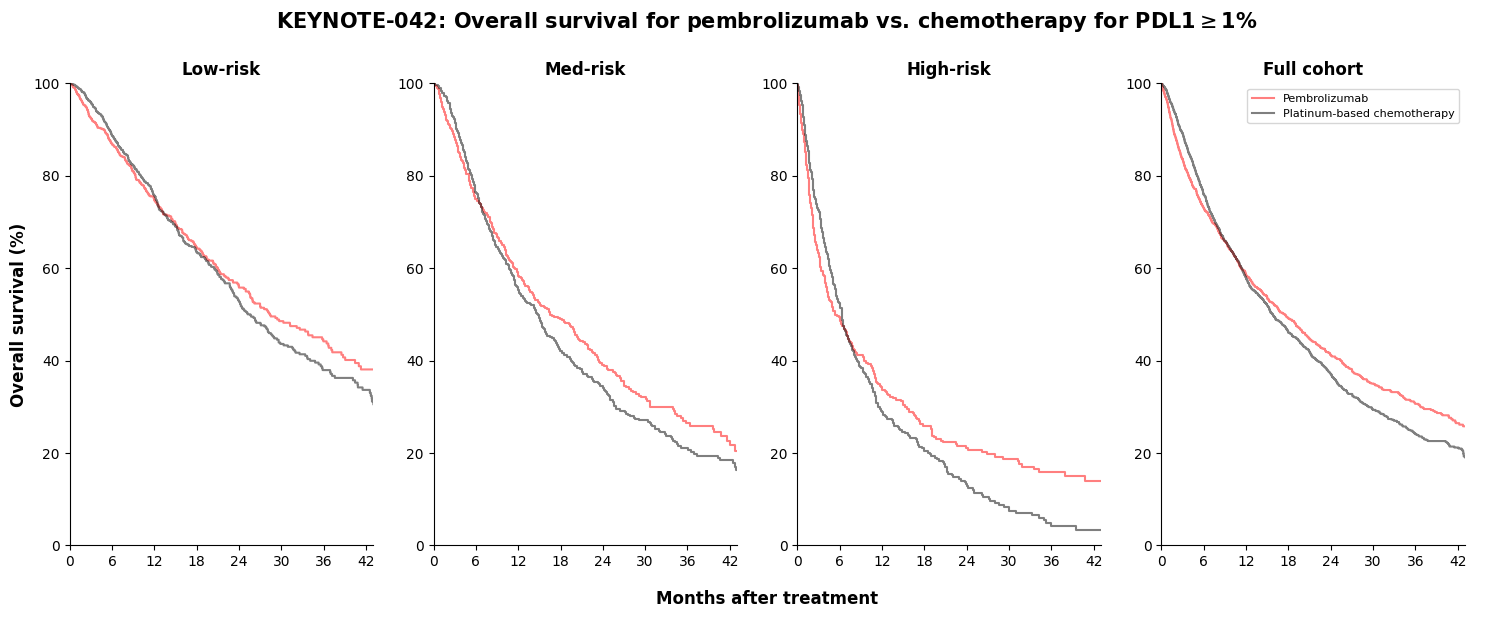

In [153]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_pembro_042, survival_prob_low_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_low_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_low_pembro]['timerisk_treatment']))

time_low_plat_042, survival_prob_low_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_low_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_042/30, survival_prob_low_pembro_042*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_042/30, survival_prob_low_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_042, survival_prob_med_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_med_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_med_pembro]['timerisk_treatment']))

time_med_plat_042, survival_prob_med_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_med_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_042/30, survival_prob_med_pembro_042*100, color = 'red', alpha = 0.5)

plt.step(time_med_plat_042/30, survival_prob_med_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_042, survival_prob_high_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_high_pembro]['death_status']),
                                                                             np.array(key_042.loc[key042_high_pembro]['timerisk_treatment']))

time_high_plat_042, survival_prob_high_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_high_plat]['death_status']),
                                                                         np.array(key_042.loc[key042_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_042/30, survival_prob_high_pembro_042*100, color = 'red', alpha = 0.5)

plt.step(time_high_plat_042/30, survival_prob_high_plat_042*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_pembro_042, survival_prob_all_pembro_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_all_pembro]['death_status']),
                                                                           np.array(key_042.loc[key042_all_pembro]['timerisk_treatment']))

time_all_plat_042, survival_prob_all_plat_042 = kaplan_meier_estimator(np.array(key_042.loc[key042_all_plat]['death_status']),
                                                                       np.array(key_042.loc[key042_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_042/30, survival_prob_all_pembro_042*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(time_all_plat_042/30, survival_prob_all_plat_042*100, color = 'black', alpha = 0.5, label = 'Platinum-based chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [154]:
key_042_iptw = key_042.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',                                       
                                       'risk_score'])

In [155]:
key_042_iptw.dtypes

death_status              bool
timerisk_treatment     float64
pembro                   int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
delta_adv_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
pdl1                    object
risk_score             float64
dtype: object

In [156]:
to_be_categorical = list(key_042_iptw.select_dtypes(include = ['object']).columns)

In [157]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis', 'pdl1']

In [158]:
to_be_categorical.append('adv_year')

In [159]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_042_iptw[x] = key_042_iptw[x].astype('category')

In [160]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [161]:
# List of categorical features.
categorical_features = list(key_042_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [162]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [163]:
key_042_iptw_low = (
    key_042_iptw
    .query('risk_score <= @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_med = (
    key_042_iptw
    .query('risk_score < @high_cutoff_042 and risk_score > @low_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_high = (
    key_042_iptw
    .query('risk_score >= @high_cutoff_042')
    .drop(columns = ['risk_score']))

key_042_iptw_all = (
    key_042_iptw
    .drop(columns = ['risk_score']))

In [164]:
key_042_low_x = preprocessor.fit_transform(key_042_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

key_042_med_x = preprocessor.fit_transform(key_042_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

key_042_high_x = preprocessor.fit_transform(key_042_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'adv_year',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_diagnosis',
                                                                              'pdl1']))

key_042_all_x = preprocessor.fit_transform(key_042_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

In [165]:
lr_042_low = LogisticRegression(max_iter = 1000)
lr_042_low.fit(key_042_low_x, key_042_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [166]:
lr_042_med = LogisticRegression(max_iter = 1000)
lr_042_med.fit(key_042_med_x, key_042_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [167]:
lr_042_high = LogisticRegression(max_iter = 1000)
lr_042_high.fit(key_042_high_x, key_042_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [168]:
lr_042_all = LogisticRegression(max_iter = 1000)
lr_042_all.fit(key_042_all_x, key_042_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [169]:
pred_low = lr_042_low.predict_proba(key_042_low_x)
pred_med = lr_042_med.predict_proba(key_042_med_x)
pred_high = lr_042_high.predict_proba(key_042_high_x)
pred_all = lr_042_all.predict_proba(key_042_all_x)

In [170]:
key_042_iptw_low['ps'] = pred_low[:, 1]
key_042_iptw_med['ps'] = pred_med[:, 1]
key_042_iptw_high['ps'] = pred_high[:, 1]
key_042_iptw_all['ps'] = pred_all[:, 1]

In [171]:
key_042_iptw_low['weight'] = (
    np.where(key_042_iptw_low['pembro'] == 1, 1/key_042_iptw_low['ps'], 1/(1 - key_042_iptw_low['ps'])))

key_042_iptw_med['weight'] = (
    np.where(key_042_iptw_med['pembro'] == 1, 1/key_042_iptw_med['ps'], 1/(1 - key_042_iptw_med['ps'])))

key_042_iptw_high['weight'] = (
    np.where(key_042_iptw_high['pembro'] == 1, 1/key_042_iptw_high['ps'], 1/(1 - key_042_iptw_high['ps'])))

key_042_iptw_all['weight'] = (
    np.where(key_042_iptw_all['pembro'] == 1, 1/key_042_iptw_all['ps'], 1/(1 - key_042_iptw_all['ps'])))

In [172]:
# Low KM curves
kmf_low_pembro_042_iptw = KaplanMeierFitter()
kmf_low_plat_042_iptw = KaplanMeierFitter()

kmf_low_pembro_042_iptw.fit(
    key_042_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 1').death_status,
    weights = key_042_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_042_iptw.fit(
    key_042_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_low.query('pembro == 0').death_status,
    weights = key_042_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_042_iptw = KaplanMeierFitter()
kmf_med_plat_042_iptw = KaplanMeierFitter()

kmf_med_pembro_042_iptw.fit(
    key_042_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 1').death_status,
    weights = key_042_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_042_iptw.fit(
    key_042_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_med.query('pembro == 0').death_status,
    weights = key_042_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_042_iptw = KaplanMeierFitter()
kmf_high_plat_042_iptw = KaplanMeierFitter()

kmf_high_pembro_042_iptw.fit(
    key_042_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 1').death_status,
    weights = key_042_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_042_iptw.fit(
    key_042_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_high.query('pembro == 0').death_status,
    weights = key_042_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_042_iptw = KaplanMeierFitter()
kmf_all_plat_042_iptw = KaplanMeierFitter()

kmf_all_pembro_042_iptw.fit(
    key_042_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 1').death_status,
    weights = key_042_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_042_iptw.fit(
    key_042_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_042_iptw_all.query('pembro == 0').death_status,
    weights = key_042_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3745.6 total observations, 1686.64 right-censored observations>

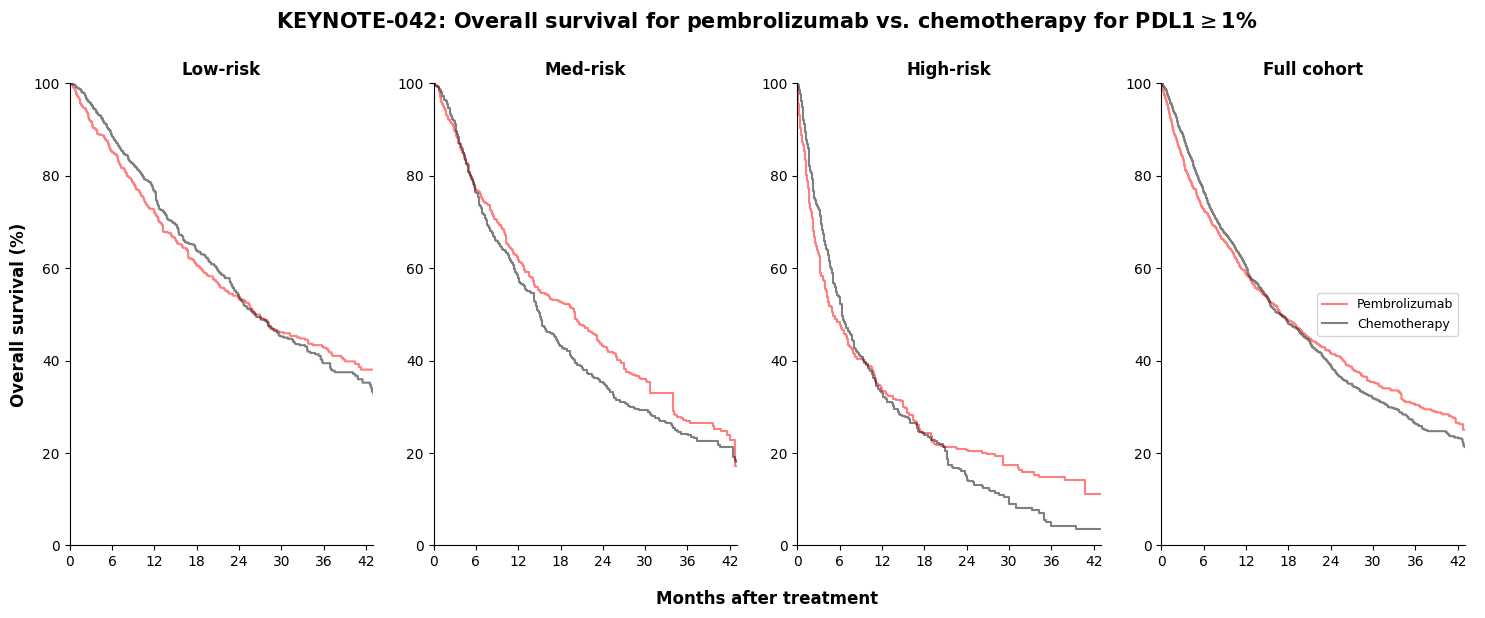

In [173]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_042_iptw.timeline, kmf_low_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_042_iptw.timeline, kmf_low_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_042_iptw.timeline, kmf_med_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_042_iptw.timeline, kmf_med_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_042_iptw.timeline, kmf_high_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_042_iptw.timeline, kmf_high_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_042_iptw.timeline, kmf_all_pembro_042_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_042_iptw.timeline, kmf_all_plat_042_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-042: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [174]:
pembro_042_12_os = psurv_t(kmf_low_pembro_042_iptw, 
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           12)

plat_042_12_os = psurv_t(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         12)

pembro_042_24_os = psurv_t(kmf_low_pembro_042_iptw, 
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           24)

plat_042_24_os = psurv_t(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         24)

pembro_042_median_os = mos(kmf_low_pembro_042_iptw,
                           kmf_med_pembro_042_iptw,
                           kmf_high_pembro_042_iptw,
                           kmf_all_pembro_042_iptw)

plat_042_median_os = mos(kmf_low_plat_042_iptw,
                         kmf_med_plat_042_iptw,
                         kmf_high_plat_042_iptw,
                         kmf_all_plat_042_iptw)

In [175]:
print('All, pembro: ',truncate(pembro_042_median_os[3], 3))
print('All, platinum: ',truncate(plat_042_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_042_median_os[0], 3))
print('Low, platinum: ',truncate(plat_042_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_042_median_os[1], 3))
print('Med, platinum: ',truncate(plat_042_median_os[1], 3))

print('High, pembro: ',truncate(pembro_042_median_os[2], 3))
print('High, platinum: ',truncate(plat_042_median_os[2], 3))

All, pembro:  16.9
All, platinum:  17.0
Low, pembro:  26.266
Low, platinum:  26.466
Med, pembro:  20.066
Med, platinum:  15.1
High, pembro:  5.033
High, platinum:  6.433


In [176]:
pembro_042_low_12_ci = psurv_ci(kmf_low_pembro_042_iptw, 12)
pembro_042_med_12_ci = psurv_ci(kmf_med_pembro_042_iptw, 12)
pembro_042_high_12_ci = psurv_ci(kmf_high_pembro_042_iptw, 12)

y_error_pembro_042_12 = y_error(pembro_042_low_12_ci,
                                pembro_042_med_12_ci,
                                pembro_042_high_12_ci,
                                pembro_042_12_os)

In [177]:
plat_042_low_12_ci = psurv_ci(kmf_low_plat_042_iptw, 12)
plat_042_med_12_ci = psurv_ci(kmf_med_plat_042_iptw, 12)
plat_042_high_12_ci = psurv_ci(kmf_high_plat_042_iptw, 12)

y_error_plat_042_12 = y_error(plat_042_low_12_ci,
                              plat_042_med_12_ci,
                              plat_042_high_12_ci,
                              plat_042_12_os)

In [178]:
pembro_042_low_24_ci = psurv_ci(kmf_low_pembro_042_iptw, 24)
pembro_042_med_24_ci = psurv_ci(kmf_med_pembro_042_iptw, 24)
pembro_042_high_24_ci = psurv_ci(kmf_high_pembro_042_iptw, 24)

y_error_pembro_042_24 = y_error(pembro_042_low_24_ci,
                                pembro_042_med_24_ci,
                                pembro_042_high_24_ci,
                                pembro_042_24_os)

In [179]:
plat_042_low_24_ci = psurv_ci(kmf_low_plat_042_iptw, 24)
plat_042_med_24_ci = psurv_ci(kmf_med_plat_042_iptw, 24)
plat_042_high_24_ci = psurv_ci(kmf_high_plat_042_iptw, 24)

y_error_plat_042_24 = y_error(plat_042_low_24_ci,
                              plat_042_med_24_ci,
                              plat_042_high_24_ci,
                              plat_042_24_os)

In [180]:
pembro_042_low_mos_ci = mos_ci(kmf_low_pembro_042_iptw)
pembro_042_med_mos_ci = mos_ci(kmf_med_pembro_042_iptw)
pembro_042_high_mos_ci = mos_ci(kmf_high_pembro_042_iptw)

y_error_pembro_042_mos = y_error(pembro_042_low_mos_ci,
                                 pembro_042_med_mos_ci,
                                 pembro_042_high_mos_ci,
                                 pembro_042_median_os)

In [181]:
plat_042_low_mos_ci = mos_ci(kmf_low_plat_042_iptw)
plat_042_med_mos_ci = mos_ci(kmf_med_plat_042_iptw)
plat_042_high_mos_ci = mos_ci(kmf_high_plat_042_iptw)

y_error_plat_042_mos = y_error(plat_042_low_mos_ci,
                               plat_042_med_mos_ci,
                               plat_042_high_mos_ci,
                               plat_042_median_os)

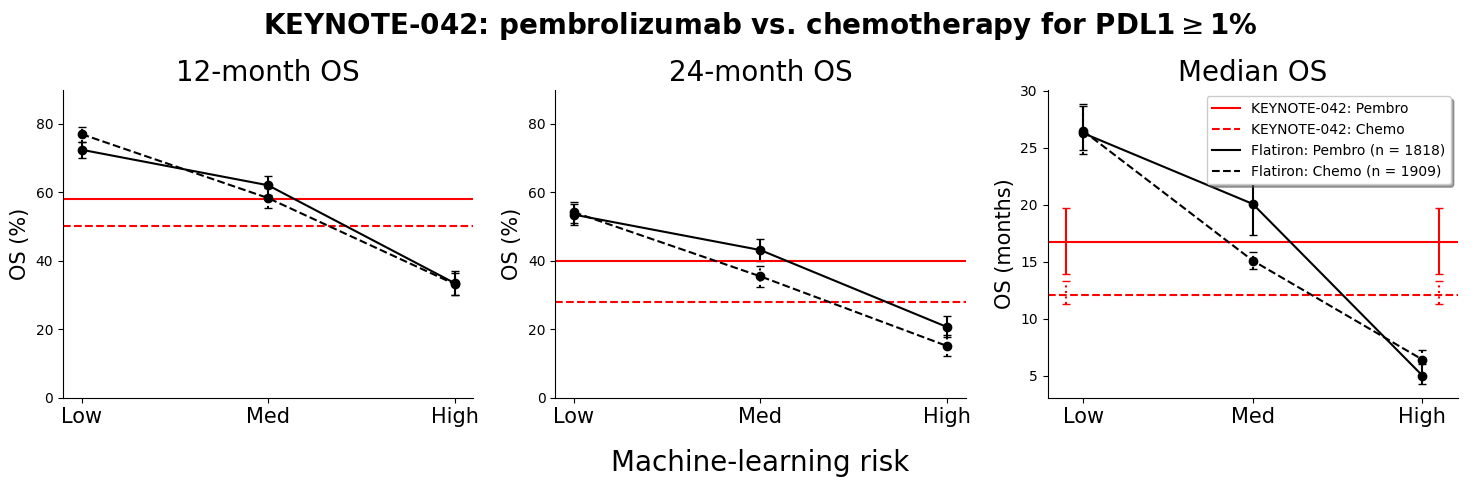

In [182]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_042_12_os, yerr = y_error_pembro_042_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 58, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_042_12_os, yerr = y_error_plat_042_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 50, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_042_24_os, yerr = y_error_pembro_042_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 40, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_042_24_os, yerr = y_error_plat_042_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 28, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_042_median_os[0:3], yerr = y_error_pembro_042_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 16.7, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 16.7, yerr=[np.array([16.7-13.9]), np.array([19.7-16.7])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, plat_042_median_os[0:3], yerr = y_error_plat_042_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 12.1, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 12.1, yerr=[np.array([12.1-11.3]), np.array([13.3-12.1])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title(r'KEYNOTE-042: pembrolizumab vs. chemotherapy for PDL1$\geq$1%', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-042: Pembro'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-042: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro (n = {})'.format(key_042.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_042.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'upper right', prop = {'size': 10})

plt.savefig('key042_summary_sc.png', bbox_inches = 'tight')

plt.show()

### KEYNOTE-024: First-line pembrolizumab vs. platinum-based chemotherapy in those with high PDL1 

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab or platinum-based chemotherapy 
* PDL1 >= 50% and status known within (-inf, +30] days of start of first-line treatment 
* EGFR and ALK negatve
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab

In [183]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [184]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [185]:
key024_pembro = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Pembrolizumab"')
    [['PatientID', 'StartDate']]
)

In [186]:
key024_pembro.loc[:, 'pembro'] = 1

In [187]:
row_ID(key024_pembro)

(3648, 3648)

In [188]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_pembro.PatientID)])

In [189]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [190]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_024_xcross = (
    line_therapy_pembro_024[line_therapy_pembro_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [191]:
# Select patients who don't receive targeted therapy in future lines.
key024_pembro = key024_pembro[~key024_pembro['PatientID'].isin(pembro_024_xcross)]

In [192]:
row_ID(key024_pembro)

(3582, 3582)

#### Platinum-based chemotherapy 

In [193]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [194]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [195]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [196]:
key024_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [197]:
key024_plat.loc[:, 'pembro'] = 0

In [198]:
row_ID(key024_plat)

(25861, 25861)

In [199]:
# Dataframe of all therapies received for those receiving first line platinum regimen  
line_therapy_plat_024 = (
    line_therapy[line_therapy['PatientID'].isin(key024_plat.PatientID)])

In [200]:
# Patients receiving platinum therapy who later recieve targeted therapy. 
plat_024_xcross = (
    line_therapy_plat_024[line_therapy_plat_024['LineName'].str.contains('|'.join(targeted))].PatientID)

In [201]:
# Select patients who don't receive targeted therapy in future lines.
key024_plat = key024_plat[~key024_plat['PatientID'].isin(plat_024_xcross)]

In [202]:
row_ID(key024_plat)

(23800, 23800)

In [203]:
key_024 = pd.concat([key024_pembro, key024_plat])

In [204]:
row_ID(key_024)

(27382, 27382)

In [205]:
key_024 = pd.merge(key_024, df_full, on = 'PatientID', how = 'inner')

In [206]:
row_ID(key_024)

(27382, 27382)

In [207]:
key_024['StartDate'] = pd.to_datetime(key_024['StartDate'])

#### High PDL1

In [208]:
biomarkers = pd.read_csv('Enhanced_AdvNSCLCBiomarkers.csv')

In [209]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(key_024['PatientID'])]

In [210]:
biomarkers = pd.merge(biomarkers, key_024[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [211]:
row_ID(biomarkers)

(94603, 19875)

In [212]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [213]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [214]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [215]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [216]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [217]:
lst = ["50% - 59%", "60% - 69%", "70% - 79%", "80% - 89%", "90% - 99%", "100%"]

pdl1_ids = (
    biomarkers
    .query('BiomarkerName == "PDL1"')
    .query('date_diff <= 30')
    .query('PercentStaining == @lst')
    .PatientID
    .unique()
)

In [218]:
key_024 = key_024[key_024.PatientID.isin(pdl1_ids)]

In [219]:
row_ID(key_024)

(3519, 3519)

#### Time from treatment to death or censor

In [220]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [221]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [222]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [223]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [224]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [225]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [226]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [227]:
key_024 = pd.merge(key_024, mortality, on = 'PatientID')

In [228]:
row_ID(key_024)

(3519, 3519)

In [229]:
conditions = [
    (key_024['death_status'] == 1),
    (key_024['death_status'] == 0)]

choices = [
    (key_024['death_date'] - key_024['StartDate']).dt.days,
    (key_024['last_activity'] - key_024['StartDate']).dt.days]

key_024.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [230]:
key_024 = key_024.query('timerisk_treatment >= 0')

#### Patient counts

In [231]:
key_024 = (
    key_024
    .query('stage == "IV"')
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [232]:
row_ID(key_024)

(2270, 2270)

In [233]:
# Exclude those with autoimmune conditions. 
key_024 = key_024[~key_024['PatientID'].isin(auto_IDs)]

In [234]:
# Exclude those with other relevant comorbidities
key_024 = key_024[~key_024['PatientID'].isin(other_comorb_IDs)]

In [235]:
# Exlcude those with CNS metastasis 
key_024 = key_024[~key_024['PatientID'].isin(cns_fl_IDs)]

In [236]:
# Include those with ECOG 2, 3, or 4 
key_024 = key_024[~key_024['PatientID'].isin(ecog_fl_IDs)]

In [237]:
# Exclude those with abnormal organ function
key_024 = key_024[~key_024['PatientID'].isin(ab_organ_IDs)]

In [238]:
row_ID(key_024)

(1410, 1410)

In [239]:
low_cutoff_024 = cutoff.loc['keynote_024'].low

In [240]:
high_cutoff_024 = cutoff.loc['keynote_024'].high

In [241]:
print('Pembro total:',  key_024.query('pembro == 1').shape[0])
print('High risk:', key_024.query('pembro == 1').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 1').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 1').query('risk_score <= @low_cutoff_024').shape[0])

Pembro total: 1087
High risk: 249
Med risk: 396
Low risk: 442


In [242]:
print('Platinum total:',  key_024.query('pembro == 0').shape[0])
print('High risk:', key_024.query('pembro == 0').query('risk_score >= @high_cutoff_024').shape[0])
print('Med risk:', key_024.query('pembro == 0').query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024').shape[0])
print('Low risk:', key_024.query('pembro == 0').query('risk_score <= @low_cutoff_024').shape[0])

Platinum total: 323
High risk: 95
Med risk: 110
Low risk: 118


#### Survival curves without confounder adjustment

In [243]:
key_024 = key_024.set_index('PatientID')

In [244]:
key024_low_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_024')
    .index)

key024_low_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_024')
    .index)

key024_med_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .index)

key024_med_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .index)

key024_high_pembro = (
    key_024
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_024')
    .index)

key024_high_plat = (
    key_024
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_024')
    .index)

key024_all_pembro = (
    key_024
    .query('pembro == 1')
    .index)

key024_all_plat = (
    key_024
    .query('pembro == 0')
    .index)

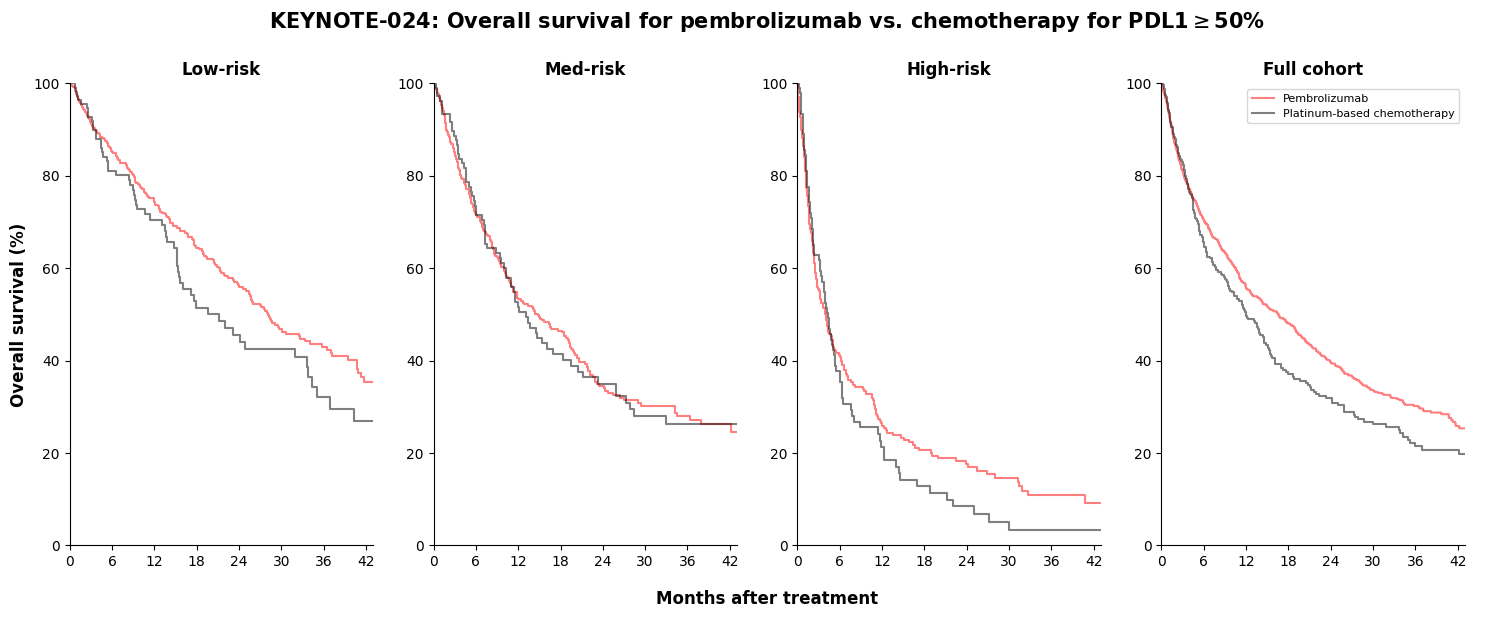

In [245]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

time_low_pembro_024, survival_prob_low_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_low_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_low_pembro]['timerisk_treatment']))

time_low_plat_024, survival_prob_low_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_low_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_024/30, survival_prob_low_pembro_024*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_024/30, survival_prob_low_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for medium risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_024, survival_prob_med_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_med_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_med_pembro]['timerisk_treatment']))

time_med_plat_024, survival_prob_med_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_med_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_024/30, survival_prob_med_pembro_024*100, color = 'red', alpha = 0.5)

plt.step(time_med_plat_024/30, survival_prob_med_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_024, survival_prob_high_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_high_pembro]['death_status']),
                                                                             np.array(key_024.loc[key024_high_pembro]['timerisk_treatment']))

time_high_plat_024, survival_prob_high_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_high_plat]['death_status']),
                                                                         np.array(key_024.loc[key024_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_024/30, survival_prob_high_pembro_024*100, color = 'red', alpha = 0.5)

plt.step(time_high_plat_024/30, survival_prob_high_plat_024*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatmetn for all 
plt.subplot(1, 4, 4)

time_all_pembro_024, survival_prob_all_pembro_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_all_pembro]['death_status']),
                                                                           np.array(key_024.loc[key024_all_pembro]['timerisk_treatment']))

time_all_plat_024, survival_prob_all_plat_024 = kaplan_meier_estimator(np.array(key_024.loc[key024_all_plat]['death_status']),
                                                                       np.array(key_024.loc[key024_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_024/30, survival_prob_all_pembro_024*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(time_all_plat_024/30, survival_prob_all_plat_024*100, color = 'black', alpha = 0.5, label = 'Platinum-based chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 8})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [246]:
key_024_iptw = key_024.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'risk_score'])

In [247]:
key_024_iptw.dtypes

death_status              bool
timerisk_treatment     float64
pembro                   int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
delta_adv_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
risk_score             float64
dtype: object

In [248]:
to_be_categorical = list(key_024_iptw.select_dtypes(include = ['object']).columns)

In [249]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis']

In [250]:
to_be_categorical.append('adv_year')

In [251]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_024_iptw[x] = key_024_iptw[x].astype('category')

In [252]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [253]:
# List of categorical features.
categorical_features = list(key_024_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [254]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [255]:
key_024_iptw_low = (
    key_024_iptw
    .query('risk_score <= @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_med = (
    key_024_iptw
    .query('risk_score < @high_cutoff_024 and risk_score > @low_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_high = (
    key_024_iptw
    .query('risk_score >= @high_cutoff_024')
    .drop(columns = ['risk_score']))

key_024_iptw_all = (
    key_024_iptw
    .drop(columns = ['risk_score']))

In [256]:
key_024_low_x = preprocessor.fit_transform(key_024_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis']))

key_024_med_x = preprocessor.fit_transform(key_024_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis']))

key_024_high_x = preprocessor.fit_transform(key_024_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'adv_year',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_diagnosis']))

key_024_all_x = preprocessor.fit_transform(key_024_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis']))

In [257]:
lr_024_low = LogisticRegression(max_iter = 1000)
lr_024_low.fit(key_024_low_x, key_024_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [258]:
lr_024_med = LogisticRegression(max_iter = 1000)
lr_024_med.fit(key_024_med_x, key_024_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [259]:
lr_024_high = LogisticRegression(max_iter = 1000)
lr_024_high.fit(key_024_high_x, key_024_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [260]:
lr_024_all = LogisticRegression(max_iter = 1000)
lr_024_all.fit(key_024_all_x, key_024_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [261]:
pred_low = lr_024_low.predict_proba(key_024_low_x)
pred_med = lr_024_med.predict_proba(key_024_med_x)
pred_high = lr_024_high.predict_proba(key_024_high_x)
pred_all = lr_024_all.predict_proba(key_024_all_x)

In [262]:
key_024_iptw_low['ps'] = pred_low[:, 1]
key_024_iptw_med['ps'] = pred_med[:, 1]
key_024_iptw_high['ps'] = pred_high[:, 1]
key_024_iptw_all['ps'] = pred_all[:, 1]

In [263]:
key_024_iptw_low['weight'] = (
    np.where(key_024_iptw_low['pembro'] == 1, 1/key_024_iptw_low['ps'], 1/(1 - key_024_iptw_low['ps'])))

key_024_iptw_med['weight'] = (
    np.where(key_024_iptw_med['pembro'] == 1, 1/key_024_iptw_med['ps'], 1/(1 - key_024_iptw_med['ps'])))

key_024_iptw_high['weight'] = (
    np.where(key_024_iptw_high['pembro'] == 1, 1/key_024_iptw_high['ps'], 1/(1 - key_024_iptw_high['ps'])))

key_024_iptw_all['weight'] = (
    np.where(key_024_iptw_all['pembro'] == 1, 1/key_024_iptw_all['ps'], 1/(1 - key_024_iptw_all['ps'])))

In [264]:
# Low KM curves
kmf_low_pembro_024_iptw = KaplanMeierFitter()
kmf_low_plat_024_iptw = KaplanMeierFitter()

kmf_low_pembro_024_iptw.fit(
    key_024_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 1').death_status,
    weights = key_024_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_024_iptw.fit(
    key_024_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_low.query('pembro == 0').death_status,
    weights = key_024_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_024_iptw = KaplanMeierFitter()
kmf_med_plat_024_iptw = KaplanMeierFitter()

kmf_med_pembro_024_iptw.fit(
    key_024_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 1').death_status,
    weights = key_024_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_024_iptw.fit(
    key_024_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_med.query('pembro == 0').death_status,
    weights = key_024_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_024_iptw = KaplanMeierFitter()
kmf_high_plat_024_iptw = KaplanMeierFitter()

kmf_high_pembro_024_iptw.fit(
    key_024_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 1').death_status,
    weights = key_024_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_024_iptw.fit(
    key_024_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_high.query('pembro == 0').death_status,
    weights = key_024_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_024_iptw = KaplanMeierFitter()
kmf_all_plat_024_iptw = KaplanMeierFitter()

kmf_all_pembro_024_iptw.fit(
    key_024_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 1').death_status,
    weights = key_024_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_024_iptw.fit(
    key_024_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_024_iptw_all.query('pembro == 0').death_status,
    weights = key_024_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1379.7 total observations, 526.303 right-censored observations>

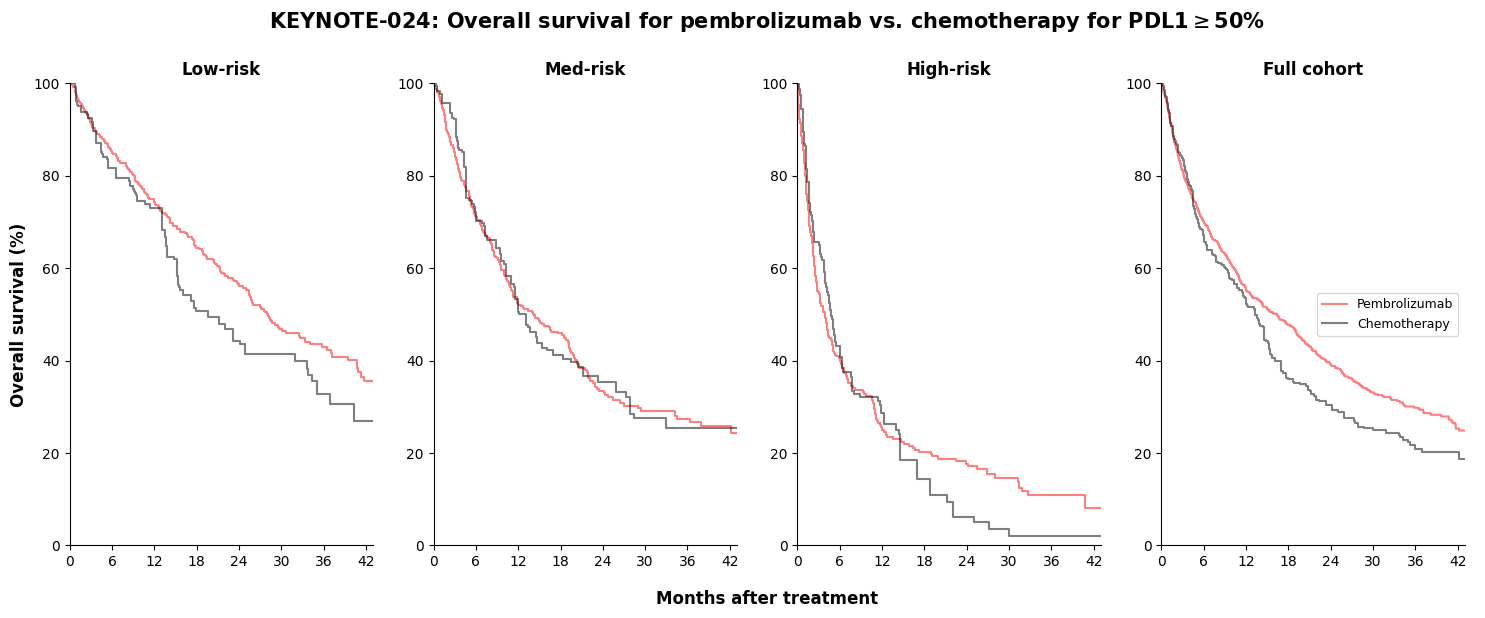

In [265]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_024_iptw.timeline, kmf_low_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_024_iptw.timeline, kmf_low_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_024_iptw.timeline, kmf_med_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_024_iptw.timeline, kmf_med_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_024_iptw.timeline, kmf_high_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_024_iptw.timeline, kmf_high_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_024_iptw.timeline, kmf_all_pembro_024_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab')

plt.step(kmf_all_plat_024_iptw.timeline, kmf_all_plat_024_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title(r'KEYNOTE-024: Overall survival for pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [266]:
pembro_024_12_os = psurv_t(kmf_low_pembro_024_iptw, 
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           12)

plat_024_12_os = psurv_t(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         12)

pembro_024_24_os = psurv_t(kmf_low_pembro_024_iptw, 
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           24)

plat_024_24_os = psurv_t(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         24)

pembro_024_median_os = mos(kmf_low_pembro_024_iptw,
                           kmf_med_pembro_024_iptw,
                           kmf_high_pembro_024_iptw,
                           kmf_all_pembro_024_iptw)

plat_024_median_os = mos(kmf_low_plat_024_iptw,
                         kmf_med_plat_024_iptw,
                         kmf_high_plat_024_iptw,
                         kmf_all_plat_024_iptw)

In [267]:
print('All, pembro: ',truncate(pembro_024_median_os[3], 3))
print('All, platinum: ',truncate(plat_024_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_024_median_os[0], 3))
print('Low, platinum: ',truncate(plat_024_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_024_median_os[1], 3))
print('Med, platinum: ',truncate(plat_024_median_os[1], 3))

print('High, pembro: ',truncate(pembro_024_median_os[2], 3))
print('High, platinum: ',truncate(plat_024_median_os[2], 3))

All, pembro:  16.4
All, platinum:  13.366
Low, pembro:  28.166
Low, platinum:  20.833
Med, pembro:  14.333
Med, platinum:  13.333
High, pembro:  3.966
High, platinum:  4.933


In [268]:
pembro_024_low_12_ci = psurv_ci(kmf_low_pembro_024_iptw, 12)
pembro_024_med_12_ci = psurv_ci(kmf_med_pembro_024_iptw, 12)
pembro_024_high_12_ci = psurv_ci(kmf_high_pembro_024_iptw, 12)

y_error_pembro_024_12 = y_error(pembro_024_low_12_ci,
                                pembro_024_med_12_ci,
                                pembro_024_high_12_ci,
                                pembro_024_12_os)

In [269]:
plat_024_low_12_ci = psurv_ci(kmf_low_plat_024_iptw, 12)
plat_024_med_12_ci = psurv_ci(kmf_med_plat_024_iptw, 12)
plat_024_high_12_ci = psurv_ci(kmf_high_plat_024_iptw, 12)

y_error_plat_024_12 = y_error(plat_024_low_12_ci,
                              plat_024_med_12_ci,
                              plat_024_high_12_ci,
                              plat_024_12_os)

In [270]:
pembro_024_low_24_ci = psurv_ci(kmf_low_pembro_024_iptw, 24)
pembro_024_med_24_ci = psurv_ci(kmf_med_pembro_024_iptw, 24)
pembro_024_high_24_ci = psurv_ci(kmf_high_pembro_024_iptw, 24)

y_error_pembro_024_24 = y_error(pembro_024_low_24_ci,
                                pembro_024_med_24_ci,
                                pembro_024_high_24_ci,
                                pembro_024_24_os)

In [271]:
plat_024_low_24_ci = psurv_ci(kmf_low_plat_024_iptw, 24)
plat_024_med_24_ci = psurv_ci(kmf_med_plat_024_iptw, 24)
plat_024_high_24_ci = psurv_ci(kmf_high_plat_024_iptw, 24)

y_error_plat_024_24 = y_error(plat_024_low_24_ci,
                              plat_024_med_24_ci,
                              plat_024_high_24_ci,
                              plat_024_24_os)

In [272]:
pembro_024_low_mos_ci = mos_ci(kmf_low_pembro_024_iptw)
pembro_024_med_mos_ci = mos_ci(kmf_med_pembro_024_iptw)
pembro_024_high_mos_ci = mos_ci(kmf_high_pembro_024_iptw)

y_error_pembro_024_mos = y_error(pembro_024_low_mos_ci,
                                 pembro_024_med_mos_ci,
                                 pembro_024_high_mos_ci,
                                 pembro_024_median_os)

In [273]:
plat_024_low_mos_ci = mos_ci(kmf_low_plat_024_iptw)
plat_024_med_mos_ci = mos_ci(kmf_med_plat_024_iptw)
plat_024_high_mos_ci = mos_ci(kmf_high_plat_024_iptw)

y_error_plat_024_mos = y_error(plat_024_low_mos_ci,
                               plat_024_med_mos_ci,
                               plat_024_high_mos_ci,
                               plat_024_median_os)

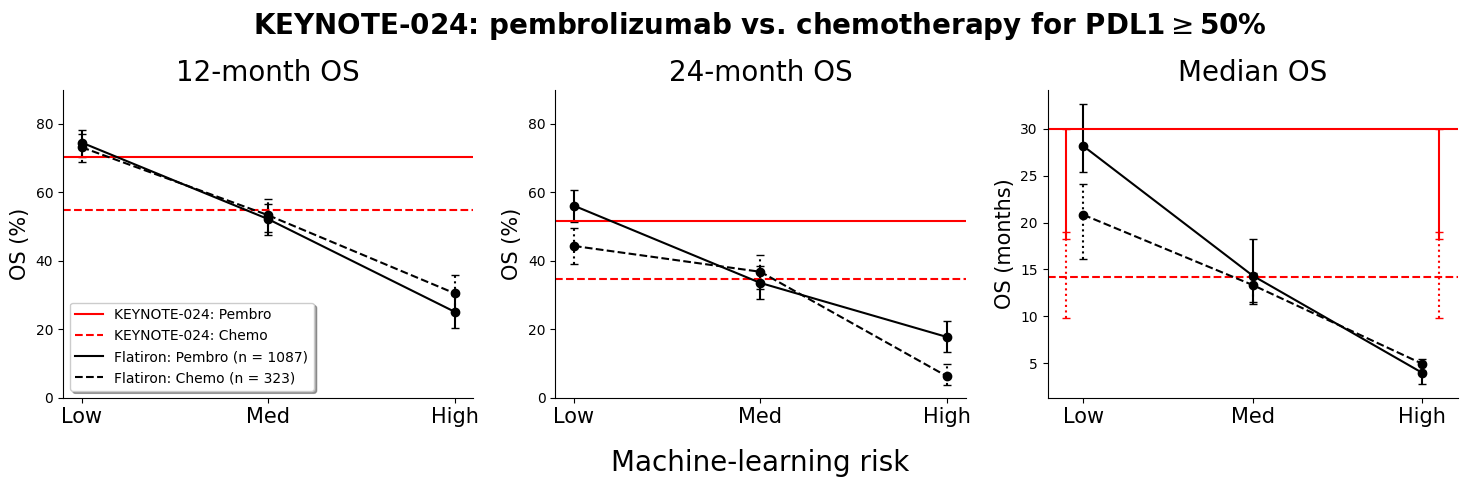

In [274]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_024_12_os, yerr = y_error_pembro_024_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 70.3, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_024_12_os, yerr = y_error_plat_024_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 54.8, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_024_24_os, yerr = y_error_pembro_024_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 51.5, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_024_24_os, yerr = y_error_plat_024_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 34.5, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_024_median_os[0:3], yerr = y_error_pembro_024_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 30.0, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 30.0, yerr=[np.array([30.0-18.3]), np.array([30.0-30.0])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, plat_024_median_os[0:3], yerr = y_error_plat_024_mos, marker = 'o', linestyle = '--', color = 'black', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 14.2, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 14.2, yerr=[np.array([14.2-9.8]), np.array([19.0-14.2])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title(r'KEYNOTE-024: pembrolizumab vs. chemotherapy for PDL1$\geq$50%', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-024: Pembro'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-024: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro (n = {})'.format(key_024.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_024.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 10})

plt.savefig('key024_summary_sc.png', bbox_inches = 'tight')

plt.show()

### KEYNOTE-189: First-line pembrolizumab plus chemotherapy vs. chemotherapy

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line pemobrolizumab plus platinum-based chemotherapy or platinum-based chemotherapy
* EGFR and ALK negative
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Pembrolizumab + chemotherapy 

In [275]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [276]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [277]:
line_therapy[line_therapy['LineName'].str.contains('Pemetrexed')].LineName.value_counts().head(10)

Carboplatin,Pemetrexed                              6700
Carboplatin,Pembrolizumab,Pemetrexed                5113
Pemetrexed                                          4711
Bevacizumab,Carboplatin,Pemetrexed                  3459
Bevacizumab,Pemetrexed                              1569
Pembrolizumab,Pemetrexed                            1554
Cisplatin,Pemetrexed                                 811
Bevacizumab,Cisplatin,Pemetrexed                     174
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed     100
Bevacizumab-Awwb,Carboplatin,Pemetrexed               82
Name: LineName, dtype: int64

In [278]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [279]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno_wout_pembro = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab']

targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [280]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Pembrolizumab,Pemetrexed                     4275
Carboplatin,Paclitaxel,Pembrolizumab                      803
Carboplatin,Paclitaxel Protein-Bound,Pembrolizumab        534
Abiraterone,Carboplatin,Pembrolizumab,Pemetrexed           79
Carboplatin,Cyclophosphamide,Pembrolizumab,Pemetrexed      31
Cisplatin,Pembrolizumab,Pemetrexed                         27
Carboplatin,Pembrolizumab                                  19
Carboplatin,Docetaxel,Pembrolizumab                        18
Carboplatin,Paclitaxel,Pembrolizumab,Pemetrexed            18
Bevacizumab,Carboplatin,Pembrolizumab,Pemetrexed           10
Name: LineName, dtype: int64

In [281]:
key189_pembro = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    line_therapy_fl['LineName'].str.contains('Pembrolizumab') &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno_wout_pembro)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [282]:
key189_pembro.loc[:, 'pembro'] = 1

In [283]:
row_ID(key189_pembro)

(5878, 5878)

In [284]:
# Dataframe of all therapies received for those receiving first line pembrolizumab only. 
line_therapy_pembro_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_pembro.PatientID)])

In [285]:
# Patients receiving pembrolizumab therapy who later recieve targeted therapy. 
pembro_189_xcross = (
    line_therapy_pembro_189[line_therapy_pembro_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [286]:
# Select patients who don't receive targeted therapy in future lines.
key189_pembro = key189_pembro[~key189_pembro['PatientID'].isin(pembro_189_xcross)]

In [287]:
row_ID(key189_pembro)

(5673, 5673)

#### Platinum-based chemotherapy

In [288]:
plat_chemo = [
    'Carboplatin',
    'Cisplatin']

immuno = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [289]:
line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')].LineName.value_counts().head(10)

Carboplatin,Paclitaxel                  8524
Carboplatin,Pemetrexed                  5417
Bevacizumab,Carboplatin,Pemetrexed      2825
Carboplatin,Paclitaxel Protein-Bound    1826
Bevacizumab,Carboplatin,Paclitaxel      1591
Carboplatin,Gemcitabine                 1224
Cisplatin,Etoposide                      793
Carboplatin,Docetaxel                    780
Cisplatin,Pemetrexed                     684
Carboplatin,Etoposide                    363
Name: LineName, dtype: int64

In [290]:
key189_plat = (
    line_therapy_fl[line_therapy_fl['LineName'].str.contains('|'.join(plat_chemo)) & 
                    ~line_therapy_fl['LineName'].str.contains('|'.join(immuno)) &
                    ~line_therapy_fl['LineName'].str.contains('|'.join(targeted)) &
                    ~line_therapy_fl['LineName'].str.contains('Clinical Study Drug')]
    [['PatientID', 'StartDate']]
)

In [291]:
key189_plat.loc[:, 'pembro'] = 0

In [292]:
row_ID(key189_plat)

(25861, 25861)

In [293]:
# Dataframe of all therapies received for those receiving first line platinum regimen 
line_therapy_plat_189 = (
    line_therapy[line_therapy['PatientID'].isin(key189_plat.PatientID)])

In [294]:
# Patients receiving platinum therapy who later recieve targeted therapy
plat_189_xcross = (
    line_therapy_plat_189[line_therapy_plat_189['LineName'].str.contains('|'.join(targeted))].PatientID)

In [295]:
# Select patients who don't receive targeted therapy
key189_plat = key189_plat[~key189_plat['PatientID'].isin(plat_189_xcross)]

In [296]:
row_ID(key189_plat)

(23800, 23800)

In [297]:
key_189 = pd.concat([key189_pembro, key189_plat])

In [298]:
row_ID(key_189)

(29473, 29473)

In [299]:
key_189 = pd.merge(key_189, df_full, on = 'PatientID', how = 'inner')

In [300]:
row_ID(key_189)

(29473, 29473)

In [301]:
key_189['StartDate'] = pd.to_datetime(key_189['StartDate'])

#### Time from treatment to death or censor

In [302]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [303]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [304]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [305]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [306]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [307]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [308]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [309]:
key_189 = pd.merge(key_189, mortality, on = 'PatientID')

In [310]:
len(key_189)

29473

In [311]:
conditions = [
    (key_189['death_status'] == 1),
    (key_189['death_status'] == 0)]

choices = [
    (key_189['death_date'] - key_189['StartDate']).dt.days,
    (key_189['last_activity'] - key_189['StartDate']).dt.days]

key_189.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [312]:
key_189 = key_189.query('timerisk_treatment >= 0')

#### Patient count

In [313]:
key_189 = (
    key_189
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [314]:
row_ID(key_189)

(29040, 29040)

In [315]:
# Exclude those with autoimmune conditions. 
key_189 = key_189[~key_189['PatientID'].isin(auto_IDs)]

In [316]:
# Exclude those with other relevant comorbidities
key_189 = key_189[~key_189['PatientID'].isin(other_comorb_IDs)]

In [317]:
# Exlcude those with CNS metastasis 
key_189 = key_189[~key_189['PatientID'].isin(cns_fl_IDs)]

In [318]:
# Exclude those with ECOG 2, 3, or 4
key_189 = key_189[~key_189['PatientID'].isin(ecog_fl_IDs)]

In [319]:
# Exclude those with abnormal organ function
key_189 = key_189[~key_189['PatientID'].isin(ab_organ_IDs)]

In [320]:
row_ID(key_189)

(21036, 21036)

In [321]:
low_cutoff_189 = cutoff.loc['keynote_189'].low

In [322]:
high_cutoff_189 = cutoff.loc['keynote_189'].high

In [323]:
print('Pembro + chemo total:',  key_189.query('pembro == 1').shape[0])
print('High risk:', key_189.query('pembro == 1').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 1').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 1').query('risk_score <= @low_cutoff_189').shape[0])

Pembro + chemo total: 3693
High risk: 1082
Med risk: 1291
Low risk: 1320


In [324]:
print('Platinum total:',  key_189.query('pembro == 0').shape[0])
print('High risk:', key_189.query('pembro == 0').query('risk_score >= @high_cutoff_189').shape[0])
print('Med risk:', key_189.query('pembro == 0').query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189').shape[0])
print('Low risk:', key_189.query('pembro == 0').query('risk_score <= @low_cutoff_189').shape[0])

Platinum total: 17343
High risk: 4609
Med risk: 5983
Low risk: 6751


#### Survival curves w/out adjusting for confounders

In [325]:
key_189 = key_189.set_index('PatientID')

In [326]:
key189_low_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score <= @low_cutoff_189')
    .index)

key189_low_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score <= @low_cutoff_189')
    .index)

key189_med_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .index)

key189_med_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .index)

key189_high_pembro = (
    key_189
    .query('pembro == 1')
    .query('risk_score >= @high_cutoff_189')
    .index)

key189_high_plat = (
    key_189
    .query('pembro == 0')
    .query('risk_score >= @high_cutoff_189')
    .index)

key189_all_pembro = (
    key_189
    .query('pembro == 1')
    .index)

key189_all_plat = (
    key_189
    .query('pembro == 0')
    .index)

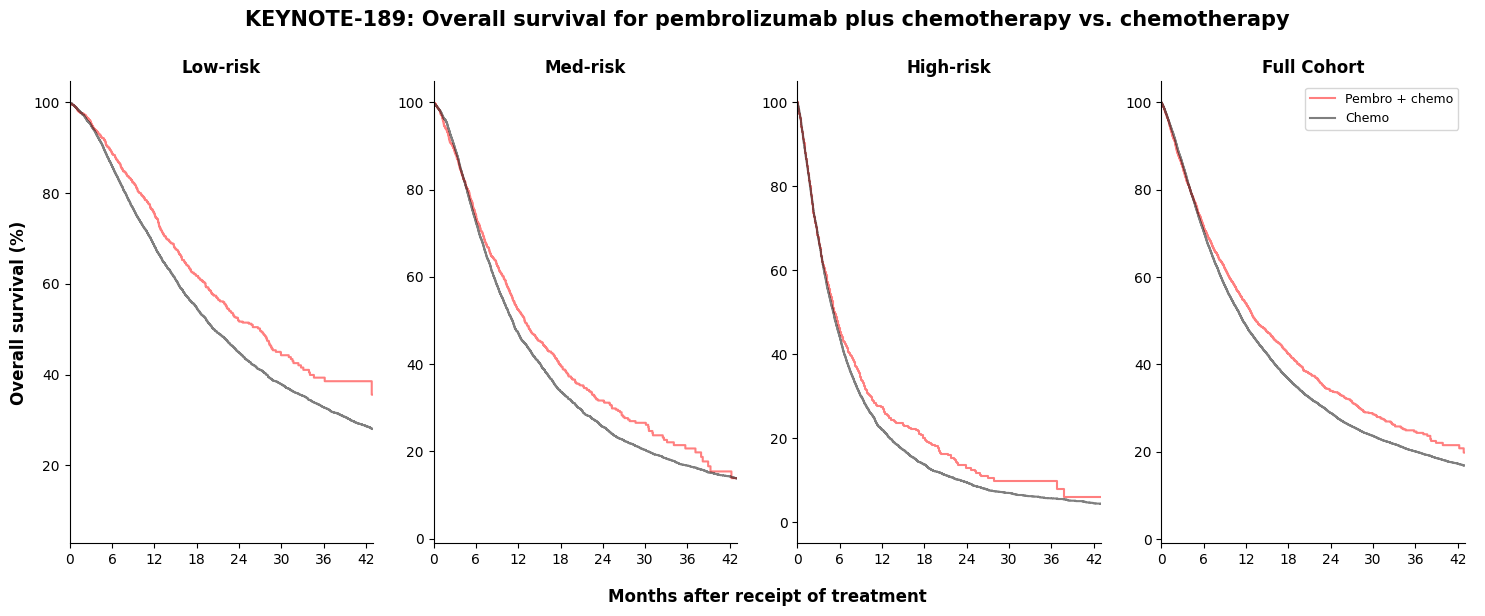

In [327]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low-risk group. 
plt.subplot(1, 4, 1)

time_low_pembro_189, survival_prob_low_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_low_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_low_pembro]['timerisk_treatment']))

time_low_plat_189, survival_prob_low_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_low_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_low_plat]['timerisk_treatment']))

plt.step(time_low_pembro_189/30, survival_prob_low_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_low_plat_189/30, survival_prob_low_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for fairly low-risk group. 
plt.subplot(1, 4, 2)

time_med_pembro_189, survival_prob_med_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_med_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_med_pembro]['timerisk_treatment']))

time_med_plat_189, survival_prob_med_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_med_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_med_plat]['timerisk_treatment']))

plt.step(time_med_pembro_189/30, survival_prob_med_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_med_plat_189/30, survival_prob_med_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high-risk group. 
plt.subplot(1, 4, 3)

time_high_pembro_189, survival_prob_high_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_high_pembro]['death_status']),
                                                                             np.array(key_189.loc[key189_high_pembro]['timerisk_treatment']))

time_high_plat_189, survival_prob_high_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_high_plat]['death_status']),
                                                                         np.array(key_189.loc[key189_high_plat]['timerisk_treatment']))

plt.step(time_high_pembro_189/30, survival_prob_high_pembro_189*100, color = 'red', alpha = 0.5)
plt.step(time_high_plat_189/30, survival_prob_high_plat_189*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all. 
plt.subplot(1, 4, 4)

time_all_pembro_189, survival_prob_all_pembro_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_all_pembro]['death_status']),
                                                                           np.array(key_189.loc[key189_all_pembro]['timerisk_treatment']))

time_all_plat_189, survival_prob_all_plat_189 = kaplan_meier_estimator(np.array(key_189.loc[key189_all_plat]['death_status']),
                                                                       np.array(key_189.loc[key189_all_plat]['timerisk_treatment']))

plt.step(time_all_pembro_189/30, survival_prob_all_pembro_189*100, color = 'red', alpha = 0.5, label = 'Pembro + chemo')
plt.step(time_all_plat_189/30, survival_prob_all_plat_189*100, color = 'black', alpha = 0.5, label = 'Chemo')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)

plt.title('Full Cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after receipt of treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [328]:
key_189_iptw = key_189.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'pembro',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [329]:
key_189_iptw.dtypes

death_status              bool
timerisk_treatment     float64
pembro                   int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
delta_adv_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
pdl1                    object
risk_score             float64
dtype: object

In [330]:
to_be_categorical = list(key_189_iptw.select_dtypes(include = ['object']).columns)

In [331]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis', 'pdl1']

In [332]:
to_be_categorical.append('adv_year')

In [333]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    key_189_iptw[x] = key_189_iptw[x].astype('category')

In [334]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [335]:
# List of categorical features.
categorical_features = list(key_189_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [336]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [337]:
key_189_iptw_low = (
    key_189_iptw
    .query('risk_score <= @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_med = (
    key_189_iptw
    .query('risk_score < @high_cutoff_189 and risk_score > @low_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_high = (
    key_189_iptw
    .query('risk_score >= @high_cutoff_189')
    .drop(columns = ['risk_score']))

key_189_iptw_all = (
    key_189_iptw
    .drop(columns = ['risk_score']))

In [338]:
key_189_low_x = preprocessor.fit_transform(key_189_iptw_low.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

key_189_med_x = preprocessor.fit_transform(key_189_iptw_med.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

key_189_high_x = preprocessor.fit_transform(key_189_iptw_high.filter(items = ['age',
                                                                              'gender',
                                                                              'race',
                                                                              'PracticeType',
                                                                              'Histology',
                                                                              'adv_year',
                                                                              'delta_adv_diagnosis',
                                                                              'commercial',
                                                                              'medicare',
                                                                              'medicaid',
                                                                              'ecog_diagnosis',
                                                                              'pdl1']))

key_189_all_x = preprocessor.fit_transform(key_189_iptw_all.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis',
                                                                            'pdl1']))

In [339]:
lr_189_low = LogisticRegression(max_iter = 1000)
lr_189_low.fit(key_189_low_x, key_189_iptw_low['pembro'])

LogisticRegression(max_iter=1000)

In [340]:
lr_189_med = LogisticRegression(max_iter = 1000)
lr_189_med.fit(key_189_med_x, key_189_iptw_med['pembro'])

LogisticRegression(max_iter=1000)

In [341]:
lr_189_high = LogisticRegression(max_iter = 1000)
lr_189_high.fit(key_189_high_x, key_189_iptw_high['pembro'])

LogisticRegression(max_iter=1000)

In [342]:
lr_189_all = LogisticRegression(max_iter = 1000)
lr_189_all.fit(key_189_all_x, key_189_iptw_all['pembro'])

LogisticRegression(max_iter=1000)

In [343]:
pred_low = lr_189_low.predict_proba(key_189_low_x)
pred_med = lr_189_med.predict_proba(key_189_med_x)
pred_high = lr_189_high.predict_proba(key_189_high_x)
pred_all = lr_189_all.predict_proba(key_189_all_x)

In [344]:
key_189_iptw_low['ps'] = pred_low[:, 1]
key_189_iptw_med['ps'] = pred_med[:, 1]
key_189_iptw_high['ps'] = pred_high[:, 1]
key_189_iptw_all['ps'] = pred_all[:, 1]

In [345]:
key_189_iptw_low['weight'] = (
    np.where(key_189_iptw_low['pembro'] == 1, 1/key_189_iptw_low['ps'], 1/(1 - key_189_iptw_low['ps'])))

key_189_iptw_med['weight'] = (
    np.where(key_189_iptw_med['pembro'] == 1, 1/key_189_iptw_med['ps'], 1/(1 - key_189_iptw_med['ps'])))

key_189_iptw_high['weight'] = (
    np.where(key_189_iptw_high['pembro'] == 1, 1/key_189_iptw_high['ps'], 1/(1 - key_189_iptw_high['ps'])))

key_189_iptw_all['weight'] = (
    np.where(key_189_iptw_all['pembro'] == 1, 1/key_189_iptw_all['ps'], 1/(1 - key_189_iptw_all['ps'])))

In [346]:
# Low KM curves
kmf_low_pembro_189_iptw = KaplanMeierFitter()
kmf_low_plat_189_iptw = KaplanMeierFitter()

kmf_low_pembro_189_iptw.fit(
    key_189_iptw_low.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 1').death_status,
    weights = key_189_iptw_low.query('pembro == 1')['weight'])

kmf_low_plat_189_iptw.fit(
    key_189_iptw_low.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_low.query('pembro == 0').death_status,
    weights = key_189_iptw_low.query('pembro == 0')['weight'])

# Med KM curves
kmf_med_pembro_189_iptw = KaplanMeierFitter()
kmf_med_plat_189_iptw = KaplanMeierFitter()

kmf_med_pembro_189_iptw.fit(
    key_189_iptw_med.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 1').death_status,
    weights = key_189_iptw_med.query('pembro == 1')['weight'])

kmf_med_plat_189_iptw.fit(
    key_189_iptw_med.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_med.query('pembro == 0').death_status,
    weights = key_189_iptw_med.query('pembro == 0')['weight'])

# High KM curves 
kmf_high_pembro_189_iptw = KaplanMeierFitter()
kmf_high_plat_189_iptw = KaplanMeierFitter()

kmf_high_pembro_189_iptw.fit(
    key_189_iptw_high.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 1').death_status,
    weights = key_189_iptw_high.query('pembro == 1')['weight'])

kmf_high_plat_189_iptw.fit(
    key_189_iptw_high.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_high.query('pembro == 0').death_status,
    weights = key_189_iptw_high.query('pembro == 0')['weight'])

# All KM curves 
kmf_all_pembro_189_iptw = KaplanMeierFitter()
kmf_all_plat_189_iptw = KaplanMeierFitter()

kmf_all_pembro_189_iptw.fit(
    key_189_iptw_all.query('pembro == 1').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 1').death_status,
    weights = key_189_iptw_all.query('pembro == 1')['weight'])

kmf_all_plat_189_iptw.fit(
    key_189_iptw_all.query('pembro == 0').timerisk_treatment/30,
    key_189_iptw_all.query('pembro == 0').death_status,
    weights = key_189_iptw_all.query('pembro == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 21076.7 total observations, 6251.02 right-censored observations>

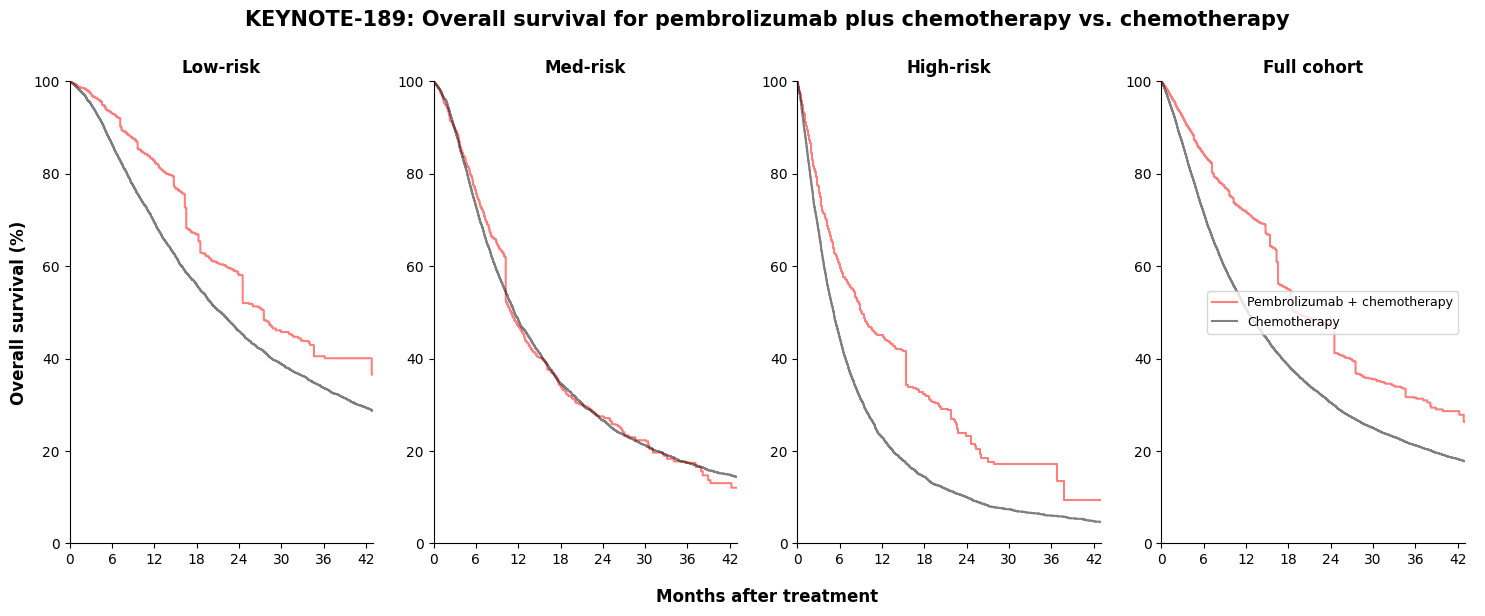

In [347]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_pembro_189_iptw.timeline, kmf_low_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_plat_189_iptw.timeline, kmf_low_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_pembro_189_iptw.timeline, kmf_med_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_plat_189_iptw.timeline, kmf_med_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_pembro_189_iptw.timeline, kmf_high_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_plat_189_iptw.timeline, kmf_high_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_pembro_189_iptw.timeline, kmf_all_pembro_189_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pembrolizumab + chemotherapy')

plt.step(kmf_all_plat_189_iptw.timeline, kmf_all_plat_189_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Chemotherapy')

plt.xticks(np.arange(0, 43, 6))
plt.xlim(0, 43)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('KEYNOTE-189: Overall survival for pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [348]:
pembro_189_12_os = psurv_t(kmf_low_pembro_189_iptw, 
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           12)

plat_189_12_os = psurv_t(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         12)

pembro_189_24_os = psurv_t(kmf_low_pembro_189_iptw, 
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           24)

plat_189_24_os = psurv_t(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         24)

pembro_189_median_os = mos(kmf_low_pembro_189_iptw,
                           kmf_med_pembro_189_iptw,
                           kmf_high_pembro_189_iptw,
                           kmf_all_pembro_189_iptw)

plat_189_median_os = mos(kmf_low_plat_189_iptw,
                         kmf_med_plat_189_iptw,
                         kmf_high_plat_189_iptw,
                         kmf_all_plat_189_iptw)

In [349]:
print('All, pembro: ',truncate(pembro_189_median_os[3], 3))
print('All, platinum: ',truncate(plat_189_median_os[3], 3))

print('Low, pembro: ',truncate(pembro_189_median_os[0], 3))
print('Low, platinum: ',truncate(plat_189_median_os[0], 3))

print('Med, pembro: ',truncate(pembro_189_median_os[1], 3))
print('Med, platinum: ',truncate(plat_189_median_os[1], 3))

print('High, pembro: ',truncate(pembro_189_median_os[2], 3))
print('High, platinum: ',truncate(plat_189_median_os[2], 3))

All, pembro:  19.233
All, platinum:  12.333
Low, pembro:  27.566
Low, platinum:  21.5
Med, pembro:  11.033
Med, platinum:  11.5
High, pembro:  9.133
High, platinum:  5.166


In [350]:
pembro_189_low_12_ci = psurv_ci(kmf_low_pembro_189_iptw, 12)
pembro_189_med_12_ci = psurv_ci(kmf_med_pembro_189_iptw, 12)
pembro_189_high_12_ci = psurv_ci(kmf_high_pembro_189_iptw, 12)

y_error_pembro_189_12 = y_error(pembro_189_low_12_ci,
                                pembro_189_med_12_ci,
                                pembro_189_high_12_ci,
                                pembro_189_12_os)

In [351]:
plat_189_low_12_ci = psurv_ci(kmf_low_plat_189_iptw, 12)
plat_189_med_12_ci = psurv_ci(kmf_med_plat_189_iptw, 12)
plat_189_high_12_ci = psurv_ci(kmf_high_plat_189_iptw, 12)

y_error_plat_189_12 = y_error(plat_189_low_12_ci,
                              plat_189_med_12_ci,
                              plat_189_high_12_ci,
                              plat_189_12_os)

In [352]:
pembro_189_low_24_ci = psurv_ci(kmf_low_pembro_189_iptw, 24)
pembro_189_med_24_ci = psurv_ci(kmf_med_pembro_189_iptw, 24)
pembro_189_high_24_ci = psurv_ci(kmf_high_pembro_189_iptw, 24)

y_error_pembro_189_24 = y_error(pembro_189_low_24_ci,
                                pembro_189_med_24_ci,
                                pembro_189_high_24_ci,
                                pembro_189_24_os)

In [353]:
plat_189_low_24_ci = psurv_ci(kmf_low_plat_189_iptw, 24)
plat_189_med_24_ci = psurv_ci(kmf_med_plat_189_iptw, 24)
plat_189_high_24_ci = psurv_ci(kmf_high_plat_189_iptw, 24)

y_error_plat_189_24 = y_error(plat_189_low_24_ci,
                              plat_189_med_24_ci,
                              plat_189_high_24_ci,
                              plat_189_24_os)

In [354]:
pembro_189_low_mos_ci = mos_ci(kmf_low_pembro_189_iptw)
pembro_189_med_mos_ci = mos_ci(kmf_med_pembro_189_iptw)
pembro_189_high_mos_ci = mos_ci(kmf_high_pembro_189_iptw)

y_error_pembro_189_mos = y_error(pembro_189_low_mos_ci,
                                 pembro_189_med_mos_ci,
                                 pembro_189_high_mos_ci,
                                 pembro_189_median_os)

In [355]:
plat_189_low_mos_ci = mos_ci(kmf_low_plat_189_iptw)
plat_189_med_mos_ci = mos_ci(kmf_med_plat_189_iptw)
plat_189_high_mos_ci = mos_ci(kmf_high_plat_189_iptw)

y_error_plat_189_mos = y_error(plat_189_low_mos_ci, 
                               plat_189_med_mos_ci, 
                               plat_189_high_mos_ci, 
                               plat_189_median_os)

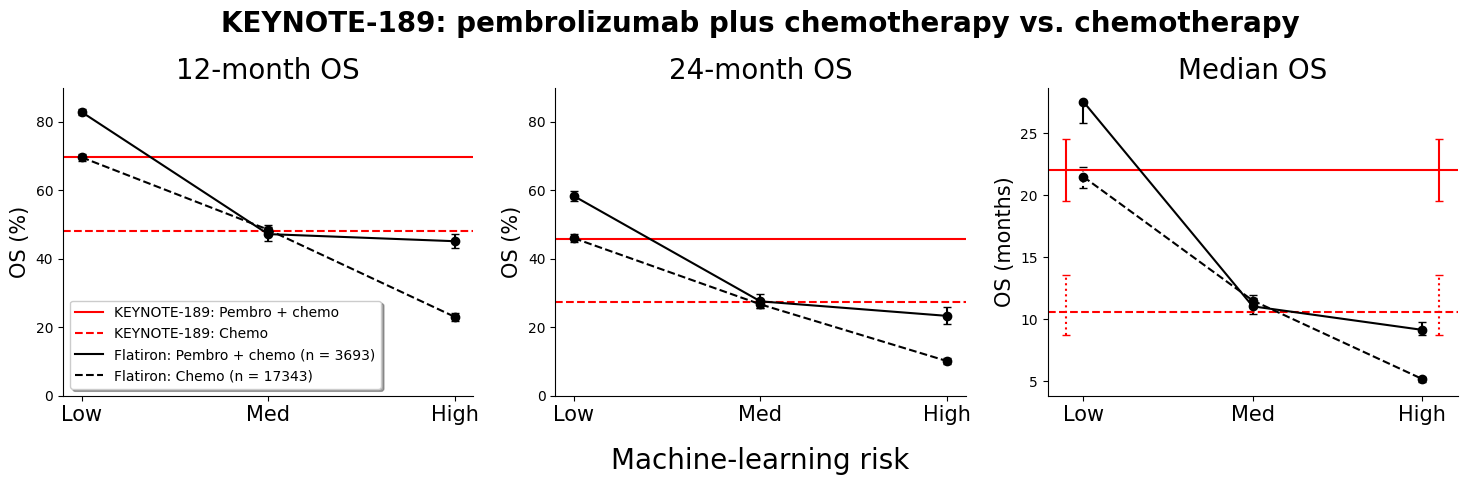

In [356]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, pembro_189_12_os, yerr = y_error_pembro_189_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 69.8, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, plat_189_12_os, yerr = y_error_plat_189_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 48.0, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, pembro_189_24_os, yerr = y_error_pembro_189_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 45.7, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, plat_189_24_os, yerr = y_error_plat_189_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 27.3, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 90)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, pembro_189_median_os[0:3], yerr = y_error_pembro_189_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 22, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 22, yerr=[np.array([22-19.5]), np.array([24.5-22])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, plat_189_median_os[0:3], yerr = y_error_plat_189_mos, marker = 'o', linestyle = '--', color = 'black', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 10.6, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 10.6, yerr=[np.array([10.6-8.7]), np.array([13.6-10.6])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('KEYNOTE-189: pembrolizumab plus chemotherapy vs. chemotherapy', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'KEYNOTE-189: Pembro + chemo'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'KEYNOTE-189: Chemo'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Pembro + chemo (n = {})'.format(key_189.query('pembro == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Chemo (n = {})'.format(key_189.query('pembro == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 10})

plt.savefig('key189_summary_sc.png', bbox_inches = 'tight')

plt.show()

### CHECKMATE-078: Second-line nivolumab vs. docetaxel

**INCLUSION CRITERIA**
* Advanced or metastatic NSCLC 
* Progressed on first line platinum-based chemotherapy 
* Received second line nivolumab or docetaxel
* Prior treatments with docetaxel or immunotherapy contraindicated
* EGFR and ALK negative 
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 

#### Nivolumab 

In [357]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [358]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [359]:
line_therapy_fl = (
    line_therapy[line_therapy.PatientID.isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
)

In [360]:
targeted = [
    'Afatinib',
    'Alectinib',
    'Brigatinib',
    'Cabozantinib',
    'Capmatinib',
    'Ceritinib',
    'Crizotinib',
    'Dabrafenib',
    'Dacomitinib',
    'Entrectinib',
    'Erlotinib',
    'Gefitinib',
    'Lorlatinib',
    'Osimertinib',
    'Pralsetinib',
    'Selpercatinib',
    'Sotorasib',
    'Tepotinib',
    'Trametinib',
    'Vandetanib']

In [361]:
immunotherapy = [
    'Atezolizumab',
    'Cemiplimab',
    'Durvalumab',
    'Ipilimumab',
    'Nivolumab',
    'Pembrolizumab'
]

In [362]:
fl_plat = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('Carboplatin|Cisplatin')
     & ~line_therapy_fl['LineName'].str.contains('Docetaxel')
     & ~line_therapy_fl['LineName'].str.contains('|'.join(targeted))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(immunotherapy))]
    .PatientID
)

In [363]:
checkmate_nivo = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Nivolumab"')
    [['PatientID', 'StartDate']]
)

In [364]:
checkmate_nivo.loc[:, 'nivo'] = 1

In [365]:
row_ID(checkmate_nivo)

(3397, 3397)

#### Docetaxel

In [366]:
checkmate_dotx = (
    line_therapy[line_therapy.PatientID.isin(fl_plat)]
    .query('LineNumber == 2')
    .query('LineName == "Docetaxel"')
    [['PatientID', 'StartDate']]
)

In [367]:
checkmate_dotx.loc[:, 'nivo'] = 0

In [368]:
row_ID(checkmate_dotx)

(745, 745)

In [369]:
checkmate = pd.concat([checkmate_nivo, checkmate_dotx])

In [370]:
row_ID(checkmate)

(4142, 4142)

In [371]:
checkmate = pd.merge(checkmate, df_full, on = 'PatientID', how = 'inner')

In [372]:
row_ID(checkmate)

(4142, 4142)

In [373]:
checkmate['StartDate'] = pd.to_datetime(checkmate['StartDate'])

#### Time from treatment to death or censor 

In [374]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [375]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [376]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [377]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [378]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
print(len(mortality), mortality.PatientID.is_unique)

68483 True


In [379]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [380]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [381]:
checkmate = pd.merge(checkmate, mortality, on = 'PatientID')

In [382]:
row_ID(checkmate)

(4142, 4142)

In [383]:
conditions = [
    (checkmate['death_status'] == 1),
    (checkmate['death_status'] == 0)]

choices = [
    (checkmate['death_date'] - checkmate['StartDate']).dt.days,
    (checkmate['last_activity'] - checkmate['StartDate']).dt.days]

checkmate.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [384]:
checkmate = checkmate.query('timerisk_treatment >= 0')

#### Patient count 

In [385]:
checkmate = (
    checkmate
    .query('EGFR != "positive"')
    .query('ALK != "positive"')
)

In [386]:
row_ID(checkmate)

(4073, 4073)

In [387]:
# Exclude those with autoimmune conditions. 
checkmate = checkmate[~checkmate['PatientID'].isin(auto_IDs)]

In [388]:
# Exclude those with other relevant comorbidities
checkmate = checkmate[~checkmate['PatientID'].isin(other_comorb_IDs)]

In [389]:
# Exlcude those with CNS metastasis 
checkmate = checkmate[~checkmate['PatientID'].isin(cns_sec_IDs)]

In [390]:
# Include only those with ECOG 2, 3, or 4 
checkmate = checkmate[~checkmate['PatientID'].isin(ecog_sec_IDs)]

In [391]:
row_ID(checkmate)

(3045, 3045)

In [392]:
low_cutoff_078 = cutoff.loc['checkmate_078'].low

In [393]:
high_cutoff_078 = cutoff.loc['checkmate_078'].high

In [394]:
print('Nivolumab total:',  checkmate.query('nivo == 1').shape[0])
print('High risk:', checkmate.query('nivo == 1').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 1').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 1').query('risk_score <= @low_cutoff_078').shape[0])

Nivolumab total: 2460
High risk: 703
Med risk: 867
Low risk: 890


In [395]:
print('Docetaxel total:',  checkmate.query('nivo == 0').shape[0])
print('High risk:', checkmate.query('nivo == 0').query('risk_score >= @high_cutoff_078').shape[0])
print('Med risk:', checkmate.query('nivo == 0').query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078').shape[0])
print('Low risk:', checkmate.query('nivo == 0').query('risk_score <= @low_cutoff_078').shape[0])

Docetaxel total: 585
High risk: 174
Med risk: 202
Low risk: 209


#### Survival curves w/out adjusting for confounders

In [396]:
checkmate = checkmate.set_index('PatientID')

In [397]:
check_low_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score <= @low_cutoff_078')
    .index)

check_low_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score <= @low_cutoff_078')
    .index)

check_med_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .index)

check_med_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .index)

check_high_nivo = (
    checkmate
    .query('nivo == 1')
    .query('risk_score >= @high_cutoff_078')
    .index)

check_high_dotx = (
    checkmate
    .query('nivo == 0')
    .query('risk_score >= @high_cutoff_078')
    .index)

check_all_nivo = (
    checkmate
    .query('nivo == 1')
    .index)

check_all_dotx = (
    checkmate
    .query('nivo == 0')
    .index)

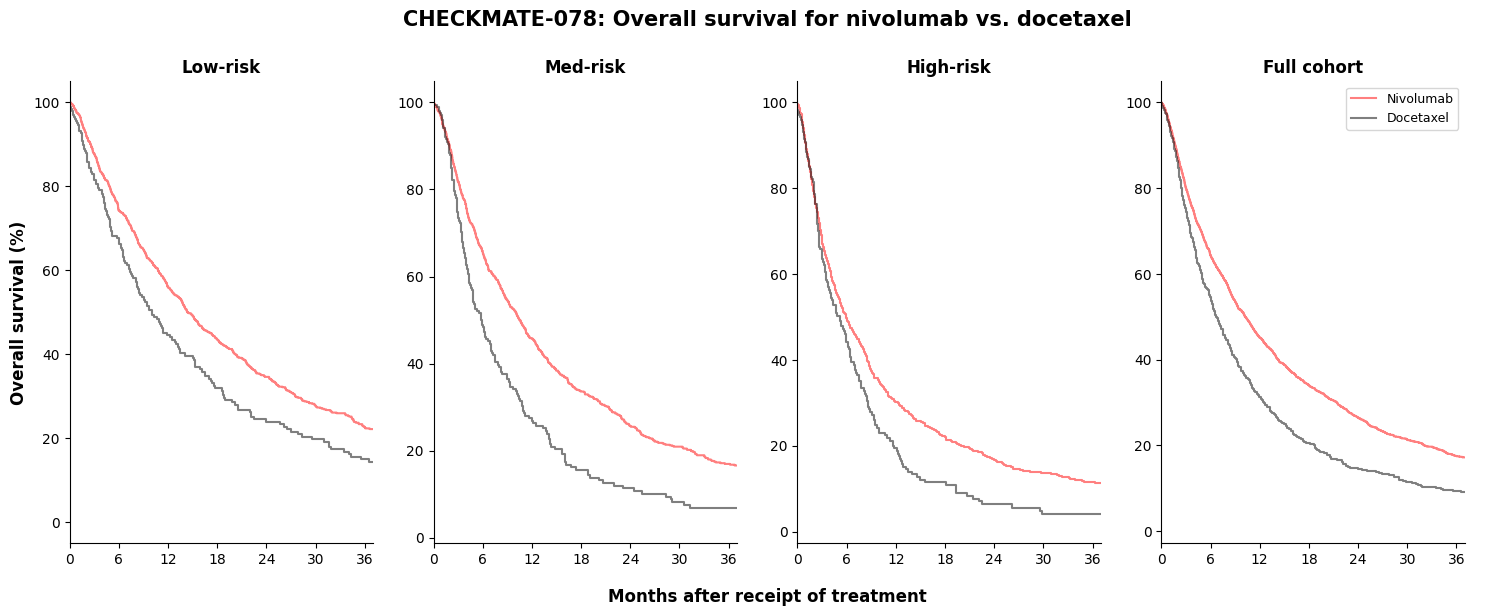

In [398]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low-risk group. 
plt.subplot(1, 4, 1)

time_low_nivo, survival_prob_low_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_low_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_low_nivo]['timerisk_treatment']))

time_low_dotx, survival_prob_low_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_low_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_low_dotx]['timerisk_treatment']))

plt.step(time_low_nivo/30, survival_prob_low_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_low_dotx/30, survival_prob_low_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for fairly low-risk group. 
plt.subplot(1, 4, 2)

time_med_nivo, survival_prob_med_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_med_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_med_nivo]['timerisk_treatment']))

time_med_dotx, survival_prob_med_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_med_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_med_dotx]['timerisk_treatment']))

plt.step(time_med_nivo/30, survival_prob_med_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_med_dotx/30, survival_prob_med_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high-risk group. 
plt.subplot(1, 4, 3)

time_high_nivo, survival_prob_high_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_high_nivo]['death_status']),
                                                                 np.array(checkmate.loc[check_high_nivo]['timerisk_treatment']))

time_high_dotx, survival_prob_high_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_high_dotx]['death_status']),
                                                                 np.array(checkmate.loc[check_high_dotx]['timerisk_treatment']))

plt.step(time_high_nivo/30, survival_prob_high_nivo*100, color = 'red', alpha = 0.5)

plt.step(time_high_dotx/30, survival_prob_high_dotx*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all. 
plt.subplot(1, 4, 4)

time_all_nivo, survival_prob_all_nivo = kaplan_meier_estimator(np.array(checkmate.loc[check_all_nivo]['death_status']),
                                                               np.array(checkmate.loc[check_all_nivo]['timerisk_treatment']))

time_all_dotx, survival_prob_all_dotx = kaplan_meier_estimator(np.array(checkmate.loc[check_all_dotx]['death_status']),
                                                               np.array(checkmate.loc[check_all_dotx]['timerisk_treatment']))

plt.step(time_all_nivo/30, survival_prob_all_nivo*100, color = 'red', alpha = 0.5, label = 'Nivolumab')

plt.step(time_all_dotx/30, survival_prob_all_dotx*100, color = 'black', alpha = 0.5, label = 'Docetaxel')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after receipt of treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Survival curves with confounder adjustment via IPTW

In [399]:
check_iptw = checkmate.filter(items = ['death_status',
                                       'timerisk_treatment',
                                       'nivo',
                                       'age',
                                       'gender',
                                       'race',
                                       'PracticeType',
                                       'Histology',
                                       'adv_year',
                                       'delta_adv_diagnosis',
                                       'commercial',
                                       'medicare',
                                       'medicaid',
                                       'ecog_diagnosis',
                                       'pdl1',
                                       'risk_score'])

In [400]:
check_iptw.dtypes

death_status              bool
timerisk_treatment     float64
nivo                     int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
delta_adv_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
pdl1                    object
risk_score             float64
dtype: object

In [401]:
to_be_categorical = list(check_iptw.select_dtypes(include = ['object']).columns)

In [402]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis', 'pdl1']

In [403]:
to_be_categorical.append('adv_year')

In [404]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    check_iptw[x] = check_iptw[x].astype('category')

In [405]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [406]:
# List of categorical features.
categorical_features = list(check_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [407]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [408]:
check_iptw_low = (
    check_iptw
    .query('risk_score <= @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_med = (
    check_iptw
    .query('risk_score < @high_cutoff_078 and risk_score > @low_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_high = (
    check_iptw
    .query('risk_score >= @high_cutoff_078')
    .drop(columns = ['risk_score']))

check_iptw_all = (
    check_iptw
    .drop(columns = ['risk_score']))

In [409]:
check_low_x = preprocessor.fit_transform(check_iptw_low.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'adv_year',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_diagnosis',
                                                                        'pdl1']))

check_med_x = preprocessor.fit_transform(check_iptw_med.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'adv_year',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_diagnosis',
                                                                        'pdl1']))

check_high_x = preprocessor.fit_transform(check_iptw_high.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_diagnosis',
                                                                          'pdl1']))

check_all_x = preprocessor.fit_transform(check_iptw_all.filter(items = ['age',
                                                                        'gender',
                                                                        'race',
                                                                        'PracticeType',
                                                                        'Histology',
                                                                        'adv_year',
                                                                        'delta_adv_diagnosis',
                                                                        'commercial',
                                                                        'medicare',
                                                                        'medicaid',
                                                                        'ecog_diagnosis',
                                                                        'pdl1']))

In [410]:
lr_check_low = LogisticRegression(max_iter = 1000)
lr_check_low.fit(check_low_x, check_iptw_low['nivo'])

LogisticRegression(max_iter=1000)

In [411]:
lr_check_med = LogisticRegression(max_iter = 1000)
lr_check_med.fit(check_med_x, check_iptw_med['nivo'])

LogisticRegression(max_iter=1000)

In [412]:
lr_check_high = LogisticRegression(max_iter = 1000)
lr_check_high.fit(check_high_x, check_iptw_high['nivo'])

LogisticRegression(max_iter=1000)

In [413]:
lr_check_all = LogisticRegression(max_iter = 1000)
lr_check_all.fit(check_all_x, check_iptw_all['nivo'])

LogisticRegression(max_iter=1000)

In [414]:
pred_low = lr_check_low.predict_proba(check_low_x)
pred_med = lr_check_med.predict_proba(check_med_x)
pred_high = lr_check_high.predict_proba(check_high_x)
pred_all = lr_check_all.predict_proba(check_all_x)

In [415]:
check_iptw_low['ps'] = pred_low[:, 1]
check_iptw_med['ps'] = pred_med[:, 1]
check_iptw_high['ps'] = pred_high[:, 1]
check_iptw_all['ps'] = pred_all[:, 1]

In [416]:
check_iptw_low['weight'] = (
    np.where(check_iptw_low['nivo'] == 1, 1/check_iptw_low['ps'], 1/(1 - check_iptw_low['ps'])))

check_iptw_med['weight'] = (
    np.where(check_iptw_med['nivo'] == 1, 1/check_iptw_med['ps'], 1/(1 - check_iptw_med['ps'])))

check_iptw_high['weight'] = (
    np.where(check_iptw_high['nivo'] == 1, 1/check_iptw_high['ps'], 1/(1 - check_iptw_high['ps'])))

check_iptw_all['weight'] = (
    np.where(check_iptw_all['nivo'] == 1, 1/check_iptw_all['ps'], 1/(1 - check_iptw_all['ps'])))

In [417]:
# Low KM curves
kmf_low_nivo_check_iptw = KaplanMeierFitter()
kmf_low_dotx_check_iptw = KaplanMeierFitter()

kmf_low_nivo_check_iptw.fit(
    check_iptw_low.query('nivo == 1').timerisk_treatment/30,
    check_iptw_low.query('nivo == 1').death_status,
    weights = check_iptw_low.query('nivo == 1')['weight'])

kmf_low_dotx_check_iptw.fit(
    check_iptw_low.query('nivo == 0').timerisk_treatment/30,
    check_iptw_low.query('nivo == 0').death_status,
    weights = check_iptw_low.query('nivo == 0')['weight'])

# Med KM curves
kmf_med_nivo_check_iptw = KaplanMeierFitter()
kmf_med_dotx_check_iptw = KaplanMeierFitter()

kmf_med_nivo_check_iptw.fit(
    check_iptw_med.query('nivo == 1').timerisk_treatment/30,
    check_iptw_med.query('nivo == 1').death_status,
    weights = check_iptw_med.query('nivo == 1')['weight'])

kmf_med_dotx_check_iptw.fit(
    check_iptw_med.query('nivo == 0').timerisk_treatment/30,
    check_iptw_med.query('nivo == 0').death_status,
    weights = check_iptw_med.query('nivo == 0')['weight'])

# High KM curves 
kmf_high_nivo_check_iptw = KaplanMeierFitter()
kmf_high_dotx_check_iptw = KaplanMeierFitter()

kmf_high_nivo_check_iptw.fit(
    check_iptw_high.query('nivo == 1').timerisk_treatment/30,
    check_iptw_high.query('nivo == 1').death_status,
    weights = check_iptw_high.query('nivo == 1')['weight'])

kmf_high_dotx_check_iptw.fit(
    check_iptw_high.query('nivo == 0').timerisk_treatment/30,
    check_iptw_high.query('nivo == 0').death_status,
    weights = check_iptw_high.query('nivo == 0')['weight'])

# All KM curves 
kmf_all_nivo_check_iptw = KaplanMeierFitter()
kmf_all_dotx_check_iptw = KaplanMeierFitter()

kmf_all_nivo_check_iptw.fit(
    check_iptw_all.query('nivo == 1').timerisk_treatment/30,
    check_iptw_all.query('nivo == 1').death_status,
    weights = check_iptw_all.query('nivo == 1')['weight'])

kmf_all_dotx_check_iptw.fit(
    check_iptw_all.query('nivo == 0').timerisk_treatment/30,
    check_iptw_all.query('nivo == 0').death_status,
    weights = check_iptw_all.query('nivo == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3012.71 total observations, 509.103 right-censored observations>

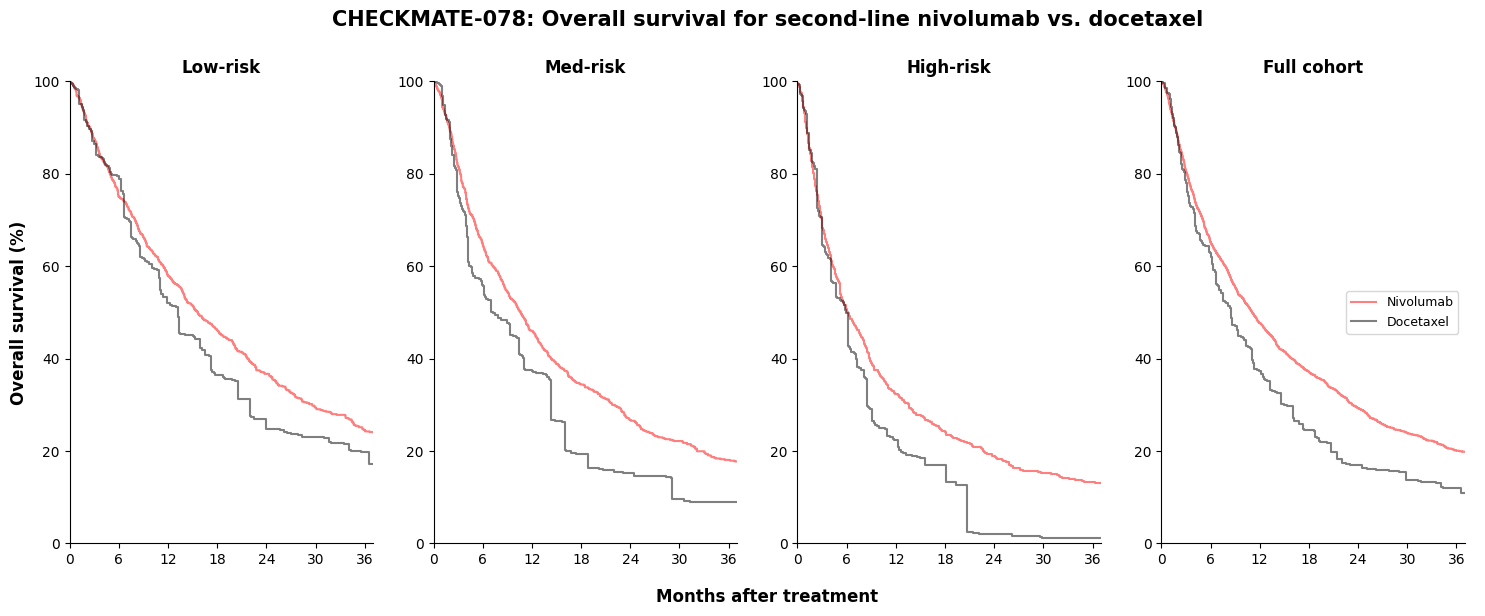

In [418]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_nivo_check_iptw.timeline, kmf_low_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_dotx_check_iptw.timeline, kmf_low_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Overall survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_nivo_check_iptw.timeline, kmf_med_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_dotx_check_iptw.timeline, kmf_med_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_nivo_check_iptw.timeline, kmf_high_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_dotx_check_iptw.timeline, kmf_high_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_nivo_check_iptw.timeline, kmf_all_nivo_check_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Nivolumab')

plt.step(kmf_all_dotx_check_iptw.timeline, kmf_all_dotx_check_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Docetaxel')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CHECKMATE-078: Overall survival for second-line nivolumab vs. docetaxel', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [419]:
nivo_check_12_os = psurv_t(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           12)

dotx_check_12_os = psurv_t(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           12)

nivo_check_24_os = psurv_t(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           24)

dotx_check_24_os = psurv_t(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           24)

nivo_check_median_os = mos(kmf_low_nivo_check_iptw, 
                           kmf_med_nivo_check_iptw,
                           kmf_high_nivo_check_iptw,
                           kmf_all_nivo_check_iptw)

dotx_check_median_os = mos(kmf_low_dotx_check_iptw,
                           kmf_med_dotx_check_iptw,
                           kmf_high_dotx_check_iptw,
                           kmf_all_dotx_check_iptw)

In [420]:
print('All, nivo: ',truncate(nivo_check_median_os[3], 3))
print('All, dotx: ',truncate(dotx_check_median_os[3], 3))

print('Low, nivo: ',truncate(nivo_check_median_os[0], 3))
print('Low, dotx: ',truncate(dotx_check_median_os[0], 3))

print('Med, nivo: ',truncate(nivo_check_median_os[1], 3))
print('Med, dotx: ',truncate(dotx_check_median_os[1], 3))

print('High, nivo: ',truncate(nivo_check_median_os[2], 3))
print('High, dotx: ',truncate(dotx_check_median_os[2], 3))

All, nivo:  11.1
All, dotx:  8.5
Low, nivo:  15.666
Low, dotx:  13.3
Med, nivo:  10.7
Med, dotx:  7.466
High, nivo:  6.233
High, dotx:  6.133


In [421]:
nivo_check_low_12_ci = psurv_ci(kmf_low_nivo_check_iptw, 12)
nivo_check_med_12_ci = psurv_ci(kmf_med_nivo_check_iptw, 12)
nivo_check_high_12_ci = psurv_ci(kmf_high_nivo_check_iptw, 12)

y_error_nivo_check_12 = y_error(nivo_check_low_12_ci,
                                nivo_check_med_12_ci,
                                nivo_check_high_12_ci,
                                nivo_check_12_os)

In [422]:
dotx_check_low_12_ci = psurv_ci(kmf_low_dotx_check_iptw, 12)
dotx_check_med_12_ci = psurv_ci(kmf_med_dotx_check_iptw, 12)
dotx_check_high_12_ci = psurv_ci(kmf_high_dotx_check_iptw, 12)

y_error_dotx_check_12 = y_error(dotx_check_low_12_ci,
                                dotx_check_med_12_ci,
                                dotx_check_high_12_ci,
                                dotx_check_12_os)

In [423]:
nivo_check_low_24_ci = psurv_ci(kmf_low_nivo_check_iptw, 24)
nivo_check_med_24_ci = psurv_ci(kmf_med_nivo_check_iptw, 24)
nivo_check_high_24_ci = psurv_ci(kmf_high_nivo_check_iptw, 24)

y_error_nivo_check_24 = y_error(nivo_check_low_24_ci,
                                nivo_check_med_24_ci,
                                nivo_check_high_24_ci,
                                nivo_check_24_os)

In [424]:
dotx_check_low_24_ci = psurv_ci(kmf_low_dotx_check_iptw, 24)
dotx_check_med_24_ci = psurv_ci(kmf_med_dotx_check_iptw, 24)
dotx_check_high_24_ci = psurv_ci(kmf_high_dotx_check_iptw, 24)

y_error_dotx_check_24 = y_error(dotx_check_low_24_ci,
                                dotx_check_med_24_ci,
                                dotx_check_high_24_ci,
                                dotx_check_24_os)

In [425]:
nivo_check_low_mos_ci = mos_ci(kmf_low_nivo_check_iptw)
nivo_check_med_mos_ci = mos_ci(kmf_med_nivo_check_iptw)
nivo_check_high_mos_ci = mos_ci(kmf_high_nivo_check_iptw)

y_error_nivo_check_mos = y_error(nivo_check_low_mos_ci,
                                 nivo_check_med_mos_ci,
                                 nivo_check_high_mos_ci, 
                                 nivo_check_median_os)

In [426]:
dotx_check_low_mos_ci = mos_ci(kmf_low_dotx_check_iptw)
dotx_check_med_mos_ci = mos_ci(kmf_med_dotx_check_iptw)
dotx_check_high_mos_ci = mos_ci(kmf_high_dotx_check_iptw)

y_error_dotx_check_mos = y_error(dotx_check_low_mos_ci,
                                 dotx_check_med_mos_ci,
                                 dotx_check_high_mos_ci,
                                 dotx_check_median_os)

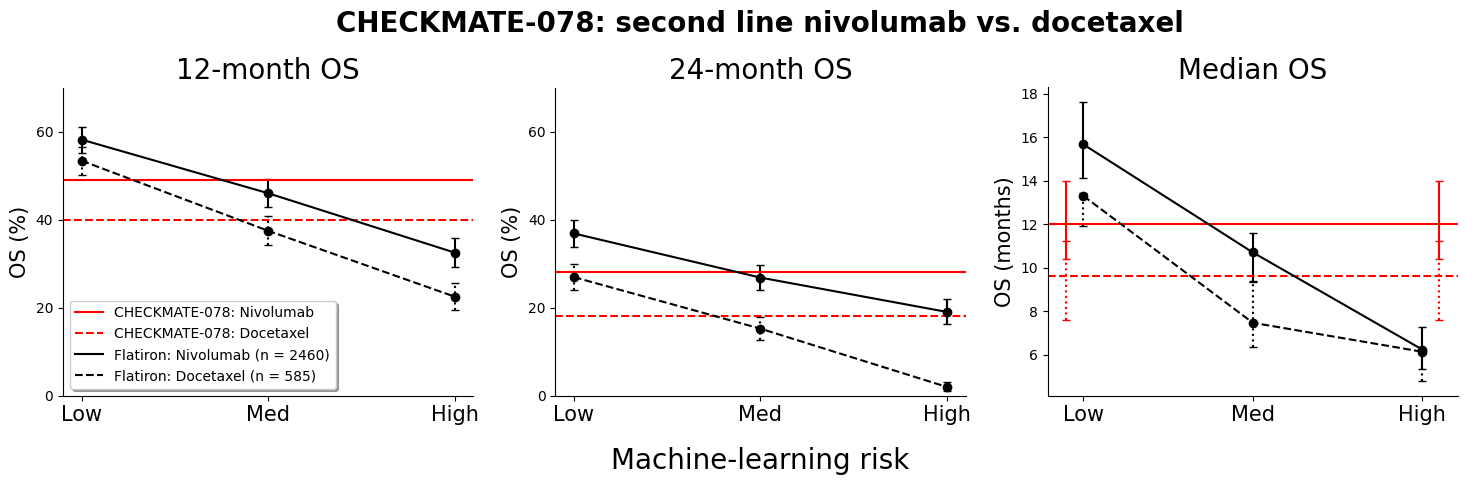

In [427]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month OS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, nivo_check_12_os, yerr = y_error_nivo_check_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 49, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, dotx_check_12_os, yerr = y_error_dotx_check_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 40, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 70)
plt.ylabel('OS (%)', size = 15)

plt.title('12-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month OS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, nivo_check_24_os, yerr = y_error_nivo_check_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 28, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, dotx_check_24_os, yerr = y_error_dotx_check_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 18, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 70)
plt.ylabel('OS (%)', size = 15)

plt.title('24-month OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median OS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, nivo_check_median_os[0:3], yerr = y_error_nivo_check_mos, marker = 'o', color = 'black', capsize = 3)

plt.axhline(y = 12.0, color = 'red', linestyle = 'solid')
x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 12.0, yerr=[np.array([12.0-10.4]), np.array([14.0-12.0])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, dotx_check_median_os[0:3], yerr = y_error_dotx_check_mos, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')

plt.axhline(y = 9.6, color = 'red', linestyle = '--')
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 9.6, yerr=[np.array([9.6-7.6]), np.array([11.2-9.6])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')

plt.xticks(fontsize = 15)
plt.ylabel('OS (months)', size = 15)

plt.title('Median OS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 20, size = 20)
plt.title('CHECKMATE-078: second line nivolumab vs. docetaxel', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'CHECKMATE-078: Nivolumab'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'CHECKMATE-078: Docetaxel'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Nivolumab (n = {})'.format(checkmate.query('nivo == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Docetaxel (n = {})'.format(checkmate.query('nivo == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 10})

plt.savefig('check078_summary_sc.png', bbox_inches = 'tight')

plt.show()

## FLAURA: osimertinib vs. gefitinib or erlotinib

**INCLUSION CRITERIA**
* Untreated stage IV NSCLC
* Received first line osimertinib or gefitinib or erlotinib
* No autoimmune diseases in the year preceding metastatic diagnosis 
* No history of ILD, HIV, Hep C, Hep B, severe psychiatric history, or drug use disorder in the year preceding metastatic diagnosis 
* No CNS metastasis at start of treatment 
* ECOG is not 2, 3, or 4 at start of treatment 
* Adeuquate organ function at start of treatment 

#### Osimertinib

In [428]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

68483

In [429]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [430]:
flaura_osim = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Osimertinib"')
    [['PatientID', 'StartDate']]
)

In [431]:
flaura_osim.loc[:, 'osim'] = 1

In [432]:
row_ID(flaura_osim)

(1241, 1241)

#### Gefitinib or Erlotinib

In [433]:
flaura_gefer = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('IsMaintenanceTherapy == False')
    .query('LineName == "Gefitinib" or LineName == "Erlotinib"')
    [['PatientID', 'StartDate']]
)

In [434]:
flaura_gefer.loc[:, 'osim'] = 0

In [435]:
row_ID(flaura_gefer)

(3003, 3003)

In [436]:
flaura = pd.concat([flaura_osim, flaura_gefer])

In [437]:
row_ID(flaura)

(4244, 4244)

In [438]:
flaura = pd.merge(flaura, df_full, on = 'PatientID', how = 'inner')

In [439]:
row_ID(flaura)

(4244, 4244)

In [440]:
flaura['StartDate'] = pd.to_datetime(flaura['StartDate'])

#### Time from treatment to death/progression or censor 

In [441]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [442]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [443]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [444]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [445]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(68483, 68483)

In [446]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [447]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [448]:
row_ID(mortality)

(68483, 68483)

In [449]:
flaura = pd.merge(flaura, mortality, on = 'PatientID', how = 'left')

In [450]:
row_ID(flaura)

(4244, 4244)

In [451]:
progression = pd.read_csv('Enhanced_AdvNSCLCProgression.csv')

In [452]:
progression = progression[progression.PatientID.isin(flaura.PatientID)][['PatientID', 'ProgressionDate']]

In [453]:
progression['ProgressionDate'] = pd.to_datetime(progression['ProgressionDate'])

In [454]:
progression = (
    progression
    .sort_values(['PatientID', 'ProgressionDate'], ascending = [True, True])
    .drop_duplicates(subset = 'PatientID', keep = 'first')
)

In [455]:
row_ID(progression)

(4243, 4243)

In [456]:
flaura = pd.merge(flaura, progression, on = 'PatientID')

In [457]:
row_ID(flaura)

(4243, 4243)

In [458]:
# Percent without progression date in Flaura trial
len(flaura.query('ProgressionDate.isna()', engine = 'python'))/len(flaura)

0.34362479377798727

In [459]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [
    (flaura['ProgressionDate'] - flaura['StartDate']).dt.days,
    (flaura['death_date'] - flaura['StartDate']).dt.days,
    (flaura['last_activity'] - flaura['StartDate']).dt.days]

flaura.loc[:, 'time_prog_treatment'] = np.select(conditions, choices)

In [460]:
flaura = flaura.query('time_prog_treatment >= 0')

In [461]:
row_ID(flaura)

(3621, 3621)

In [462]:
conditions = [
    (flaura.ProgressionDate.notna()),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 1)),
    ((flaura.ProgressionDate.isna()) & (flaura['death_status'] == 0))]

choices = [1, 1, 0]

flaura.loc[:, 'pfs_status'] = np.select(conditions, choices)

#### Patient count

In [463]:
row_ID(flaura)

(3621, 3621)

In [464]:
# Exclude those with autoimmune conditions. 
flaura = flaura[~flaura['PatientID'].isin(auto_IDs)]

In [465]:
# Exclude those with other relevant comorbidities
flaura = flaura[~flaura['PatientID'].isin(other_comorb_IDs)]

In [466]:
# Exlcude those with CNS metastasis 
flaura = flaura[~flaura['PatientID'].isin(cns_fl_IDs)]

In [467]:
# Exclude those with ECOG 2, 3, or 4
flaura = flaura[~flaura['PatientID'].isin(ecog_fl_IDs)]

In [468]:
# Exclude those with abnormal organ function
flaura = flaura[~flaura['PatientID'].isin(ab_organ_IDs)]

In [469]:
row_ID(flaura)

(2724, 2724)

In [470]:
low_cutoff_fl = cutoff.loc['flaura'].low

In [471]:
high_cutoff_fl = cutoff.loc['flaura'].high

In [472]:
print('Osimertinib total:', flaura.query('osim == 1').shape[0])
print('High risk:', flaura.query('osim == 1').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 1').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 1').query('risk_score <= @low_cutoff_fl').shape[0])

Osimertinib total: 751
High risk: 159
Med risk: 234
Low risk: 358


In [473]:
print('Gefitinib or Erlotinib total:', flaura.query('osim == 0').shape[0])
print('High risk:', flaura.query('osim == 0').query('risk_score >= @high_cutoff_fl').shape[0])
print('Med risk:', flaura.query('osim == 0').query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl').shape[0])
print('Low risk:', flaura.query('osim == 0').query('risk_score <= @low_cutoff_fl').shape[0])

Gefitinib or Erlotinib total: 1973
High risk: 579
Med risk: 725
Low risk: 669


#### rwPFS with confounder adjustment via IPTW

In [474]:
flaura = flaura.set_index('PatientID')

In [475]:
flaura_iptw = flaura.filter(items = ['pfs_status',
                                     'time_prog_treatment',
                                     'osim',
                                     'age',
                                     'gender',
                                     'race',
                                     'PracticeType',
                                     'Histology',
                                     'adv_year',
                                     'delta_adv_diagnosis',
                                     'commercial',
                                     'medicare',
                                     'medicaid',
                                     'ecog_diagnosis',
                                     'risk_score'])

In [476]:
flaura_iptw.dtypes

pfs_status               int64
time_prog_treatment    float64
osim                     int64
age                      int64
gender                  object
race                    object
PracticeType            object
Histology               object
adv_year                 int64
delta_adv_diagnosis      int64
commercial             float64
medicare               float64
medicaid               float64
ecog_diagnosis          object
risk_score             float64
dtype: object

In [477]:
to_be_categorical = list(flaura_iptw.select_dtypes(include = ['object']).columns)

In [478]:
to_be_categorical

['gender', 'race', 'PracticeType', 'Histology', 'ecog_diagnosis']

In [479]:
to_be_categorical.append('adv_year')

In [480]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    flaura_iptw[x] = flaura_iptw[x].astype('category')

In [481]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_adv_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [482]:
# List of categorical features.
categorical_features = list(flaura_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [483]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [484]:
flaura_iptw_low = (
    flaura_iptw
    .query('risk_score <= @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_med = (
    flaura_iptw
    .query('risk_score < @high_cutoff_fl and risk_score > @low_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_high = (
    flaura_iptw
    .query('risk_score >= @high_cutoff_fl')
    .drop(columns = ['risk_score']))

flaura_iptw_all = (
    flaura_iptw
    .drop(columns = ['risk_score']))

In [485]:
flaura_low_x = preprocessor.fit_transform(flaura_iptw_low.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_diagnosis',]))

flaura_med_x = preprocessor.fit_transform(flaura_iptw_med.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_diagnosis']))

flaura_high_x = preprocessor.fit_transform(flaura_iptw_high.filter(items = ['age',
                                                                            'gender',
                                                                            'race',
                                                                            'PracticeType',
                                                                            'Histology',
                                                                            'adv_year',
                                                                            'delta_adv_diagnosis',
                                                                            'commercial',
                                                                            'medicare',
                                                                            'medicaid',
                                                                            'ecog_diagnosis']))

flaura_all_x = preprocessor.fit_transform(flaura_iptw_all.filter(items = ['age',
                                                                          'gender',
                                                                          'race',
                                                                          'PracticeType',
                                                                          'Histology',
                                                                          'adv_year',
                                                                          'delta_adv_diagnosis',
                                                                          'commercial',
                                                                          'medicare',
                                                                          'medicaid',
                                                                          'ecog_diagnosis']))


In [486]:
lr_flaura_low = LogisticRegression(max_iter = 1000)
lr_flaura_low.fit(flaura_low_x, flaura_iptw_low['osim'])

LogisticRegression(max_iter=1000)

In [487]:
lr_flaura_med = LogisticRegression(max_iter = 1000)
lr_flaura_med.fit(flaura_med_x, flaura_iptw_med['osim'])

LogisticRegression(max_iter=1000)

In [488]:
lr_flaura_high = LogisticRegression(max_iter = 1000)
lr_flaura_high.fit(flaura_high_x, flaura_iptw_high['osim'])

LogisticRegression(max_iter=1000)

In [489]:
lr_flaura_all = LogisticRegression(max_iter = 1000)
lr_flaura_all.fit(flaura_all_x, flaura_iptw_all['osim'])

LogisticRegression(max_iter=1000)

In [490]:
pred_low = lr_flaura_low.predict_proba(flaura_low_x)
pred_med = lr_flaura_med.predict_proba(flaura_med_x)
pred_high = lr_flaura_high.predict_proba(flaura_high_x)
pred_all = lr_flaura_all.predict_proba(flaura_all_x)

In [491]:
flaura_iptw_low['ps'] = pred_low[:, 1]
flaura_iptw_med['ps'] = pred_med[:, 1]
flaura_iptw_high['ps'] = pred_high[:, 1]
flaura_iptw_all['ps'] = pred_all[:, 1]

In [492]:
flaura_iptw_low['weight'] = (
    np.where(flaura_iptw_low['osim'] == 1, 1/flaura_iptw_low['ps'], 1/(1 - flaura_iptw_low['ps'])))

flaura_iptw_med['weight'] = (
    np.where(flaura_iptw_med['osim'] == 1, 1/flaura_iptw_med['ps'], 1/(1 - flaura_iptw_med['ps'])))

flaura_iptw_high['weight'] = (
    np.where(flaura_iptw_high['osim'] == 1, 1/flaura_iptw_high['ps'], 1/(1 - flaura_iptw_high['ps'])))

flaura_iptw_all['weight'] = (
    np.where(flaura_iptw_all['osim'] == 1, 1/flaura_iptw_all['ps'], 1/(1 - flaura_iptw_all['ps'])))

In [493]:
# Low KM curves
kmf_low_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_low_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_low_osim_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 1').pfs_status,
    weights = flaura_iptw_low.query('osim == 1')['weight'])

kmf_low_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_low.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_low.query('osim == 0').pfs_status,
    weights = flaura_iptw_low.query('osim == 0')['weight'])

# Med KM curves
kmf_med_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_med_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_med_osim_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 1').pfs_status,
    weights = flaura_iptw_med.query('osim == 1')['weight'])

kmf_med_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_med.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_med.query('osim == 0').pfs_status,
    weights = flaura_iptw_med.query('osim == 0')['weight'])

# High KM curves 
kmf_high_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_high_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_high_osim_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 1').pfs_status,
    weights = flaura_iptw_high.query('osim == 1')['weight'])

kmf_high_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_high.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_high.query('osim == 0').pfs_status,
    weights = flaura_iptw_high.query('osim == 0')['weight'])

# All KM curves 
kmf_all_osim_flaura_iptw_pfs = KaplanMeierFitter()
kmf_all_gefer_flaura_iptw_pfs = KaplanMeierFitter()

kmf_all_osim_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 1').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 1').pfs_status,
    weights = flaura_iptw_all.query('osim == 1')['weight'])

kmf_all_gefer_flaura_iptw_pfs.fit(
    flaura_iptw_all.query('osim == 0').time_prog_treatment/30,
    flaura_iptw_all.query('osim == 0').pfs_status,
    weights = flaura_iptw_all.query('osim == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2470.78 total observations, 335.504 right-censored observations>

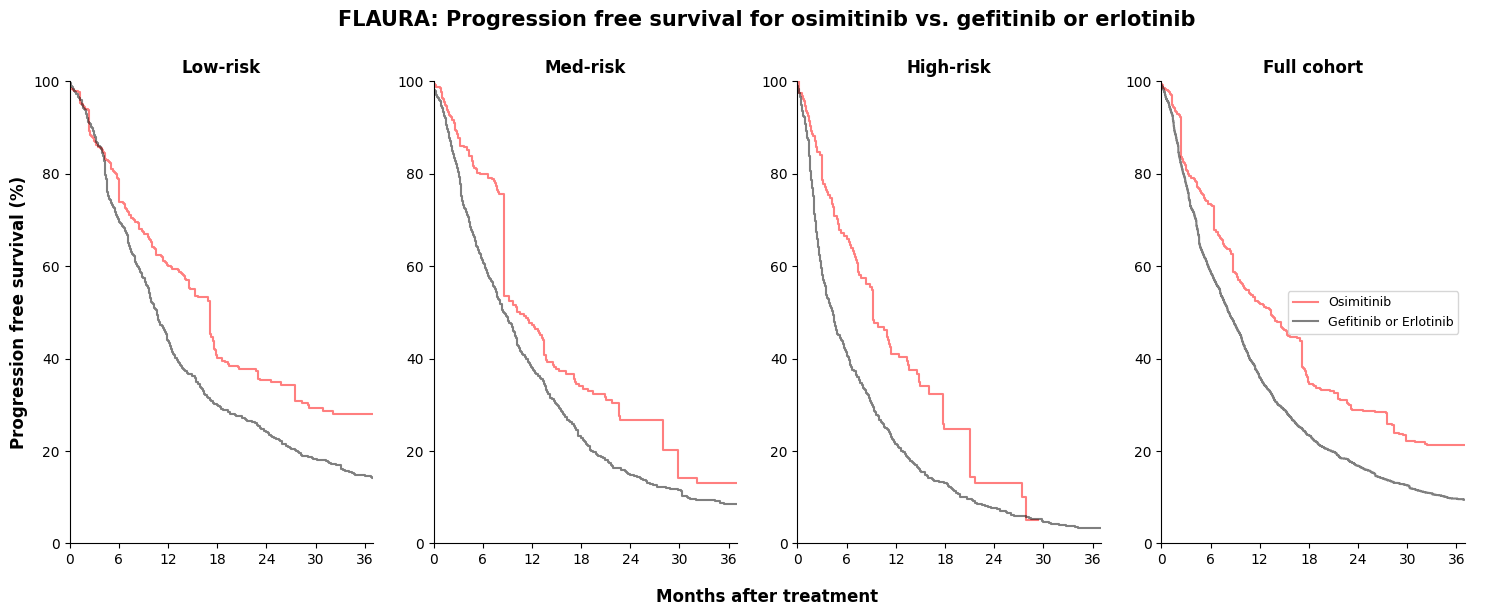

In [494]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_osim_flaura_iptw_pfs.timeline, kmf_low_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_gefer_flaura_iptw_pfs.timeline, kmf_low_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('Progression free survival (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_osim_flaura_iptw_pfs.timeline, kmf_med_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_gefer_flaura_iptw_pfs.timeline, kmf_med_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_osim_flaura_iptw_pfs.timeline, kmf_high_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_gefer_flaura_iptw_pfs.timeline, kmf_high_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_osim_flaura_iptw_pfs.timeline, kmf_all_osim_flaura_iptw_pfs.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Osimitinib')

plt.step(kmf_all_gefer_flaura_iptw_pfs.timeline, kmf_all_gefer_flaura_iptw_pfs.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Gefitinib or Erlotinib')

plt.xticks(np.arange(0, 37, 6))
plt.xlim(0, 37)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'center right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('FLAURA: Progression free survival for osimitinib vs. gefitinib or erlotinib', pad = 40, size = 15, weight = 'bold')

plt.show()

#### Summary result plot 

In [495]:
osim_flaura_12_pfs = psurv_t(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             12)

gefer_flaura_12_pfs = psurv_t(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              12)

osim_flaura_24_pfs = psurv_t(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             24)

gefer_flaura_24_pfs = psurv_t(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              24)

osim_flaura_median_pfs = mos(kmf_low_osim_flaura_iptw_pfs,
                             kmf_med_osim_flaura_iptw_pfs,
                             kmf_high_osim_flaura_iptw_pfs,
                             kmf_all_osim_flaura_iptw_pfs)

gefer_flaura_median_pfs = mos(kmf_low_gefer_flaura_iptw_pfs,
                              kmf_med_gefer_flaura_iptw_pfs,
                              kmf_high_gefer_flaura_iptw_pfs,
                              kmf_all_gefer_flaura_iptw_pfs)

In [496]:
print('All, osim: ',truncate(osim_flaura_median_pfs[3], 3))
print('All, gefer: ',truncate(gefer_flaura_median_pfs[3], 3))

print('Low, osim: ',truncate(osim_flaura_median_pfs[0], 3))
print('Low, gefer: ',truncate(gefer_flaura_median_pfs[0], 3))

print('Med, osim: ',truncate(osim_flaura_median_pfs[1], 3))
print('Med, gefer: ',truncate(gefer_flaura_median_pfs[1], 3))

print('High, osim: ',truncate(osim_flaura_median_pfs[2], 3))
print('High, gefer: ',truncate(gefer_flaura_median_pfs[2], 3))

All, osim:  13.466
All, gefer:  8.3
Low, osim:  17.133
Low, gefer:  10.7
Med, osim:  10.7
Med, gefer:  8.7
High, osim:  9.3
High, gefer:  4.366


In [497]:
osim_flaura_low_12_ci = psurv_ci(kmf_low_osim_flaura_iptw_pfs, 12)
osim_flaura_med_12_ci = psurv_ci(kmf_med_osim_flaura_iptw_pfs, 12)
osim_flaura_high_12_ci = psurv_ci(kmf_high_osim_flaura_iptw_pfs, 12)

y_error_osim_flaura_12 = y_error(osim_flaura_low_12_ci,
                                 osim_flaura_med_12_ci,
                                 osim_flaura_high_12_ci,
                                 osim_flaura_12_pfs)

In [498]:
gefer_flaura_low_12_ci = psurv_ci(kmf_low_gefer_flaura_iptw_pfs, 12)
gefer_flaura_med_12_ci = psurv_ci(kmf_med_gefer_flaura_iptw_pfs, 12)
gefer_flaura_high_12_ci = psurv_ci(kmf_high_gefer_flaura_iptw_pfs, 12)

y_error_gefer_flaura_12 = y_error(gefer_flaura_low_12_ci,
                                  gefer_flaura_med_12_ci,
                                  gefer_flaura_high_12_ci,
                                  gefer_flaura_12_pfs)

In [499]:
osim_flaura_low_24_ci = psurv_ci(kmf_low_osim_flaura_iptw_pfs, 24)
osim_flaura_med_24_ci = psurv_ci(kmf_med_osim_flaura_iptw_pfs, 24)
osim_flaura_high_24_ci = psurv_ci(kmf_high_osim_flaura_iptw_pfs, 24)

y_error_osim_flaura_24 = y_error(osim_flaura_low_24_ci,
                                 osim_flaura_med_24_ci,
                                 osim_flaura_high_24_ci,
                                 osim_flaura_24_pfs)

In [500]:
gefer_flaura_low_24_ci = psurv_ci(kmf_low_gefer_flaura_iptw_pfs, 24)
gefer_flaura_med_24_ci = psurv_ci(kmf_med_gefer_flaura_iptw_pfs, 24)
gefer_flaura_high_24_ci = psurv_ci(kmf_high_gefer_flaura_iptw_pfs, 24)

y_error_gefer_flaura_24 = y_error(gefer_flaura_low_24_ci,
                                  gefer_flaura_med_24_ci,
                                  gefer_flaura_high_24_ci,
                                  gefer_flaura_24_pfs)

In [501]:
osim_flaura_low_mpfs_ci = mos_ci(kmf_low_osim_flaura_iptw_pfs)
osim_flaura_med_mpfs_ci = mos_ci(kmf_med_osim_flaura_iptw_pfs)
osim_flaura_high_mpfs_ci = mos_ci(kmf_high_osim_flaura_iptw_pfs)

y_error_osim_flaura_mpfs = y_error(osim_flaura_low_mpfs_ci,
                                   osim_flaura_med_mpfs_ci,
                                   osim_flaura_high_mpfs_ci,
                                   osim_flaura_median_pfs)

In [502]:
gefer_flaura_low_mpfs_ci = mos_ci(kmf_low_gefer_flaura_iptw_pfs)
gefer_flaura_med_mpfs_ci = mos_ci(kmf_med_gefer_flaura_iptw_pfs)
gefer_flaura_high_mpfs_ci = mos_ci(kmf_high_gefer_flaura_iptw_pfs)

y_error_gefer_flaura_mpfs = y_error(gefer_flaura_low_mpfs_ci,
                                    gefer_flaura_med_mpfs_ci,
                                    gefer_flaura_high_mpfs_ci,
                                    gefer_flaura_median_pfs)

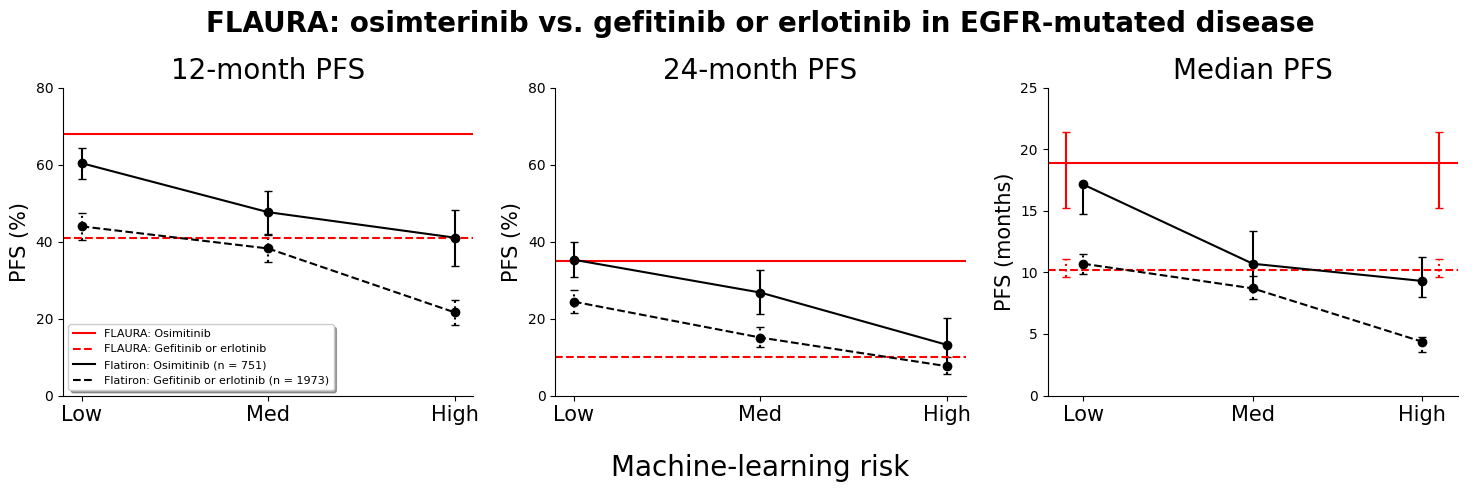

In [503]:
ml_risk = ['Low', 'Med',  'High']

fig = plt.figure(figsize=(18, 4))

# 12 month PFS plot
plt.subplot(1, 3, 1)
plt.errorbar(ml_risk, osim_flaura_12_pfs, yerr = y_error_osim_flaura_12, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 68, color = 'red', linestyle = 'solid')

eb1 = plt.errorbar(ml_risk, gefer_flaura_12_pfs, yerr = y_error_gefer_flaura_12, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb1[-1][0].set_linestyle(':')
plt.axhline(y = 41, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 80)
plt.ylabel('PFS (%)', size = 15)

plt.title('12-month PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 24 month PFS plot
plt.subplot(1, 3, 2)
plt.errorbar(ml_risk, osim_flaura_24_pfs, yerr = y_error_osim_flaura_24, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 35, color = 'red', linestyle = 'solid')

eb2 = plt.errorbar(ml_risk, gefer_flaura_24_pfs, yerr = y_error_gefer_flaura_24, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb2[-1][0].set_linestyle(':')
plt.axhline(y = 10, color = 'red', linestyle = '--')

plt.xticks(fontsize = 15)
plt.yticks(np.arange(0, 110, 20))
plt.ylim(0, 80)
plt.ylabel('PFS (%)', size = 15)

plt.title('24-month PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Median PFS plot
plt.subplot(1, 3, 3)
plt.errorbar(ml_risk, osim_flaura_median_pfs[0:3], yerr = y_error_osim_flaura_mpfs, marker = 'o', color = 'black', capsize = 3)
plt.axhline(y = 18.9, color = 'red', linestyle = 'solid')

x_positions = [-0.1, 2.1]
for x in x_positions:
    plt.errorbar(x, 18.9, yerr=[np.array([18.9-15.2]), np.array([21.4-18.9])], color = 'red', capsize = 3)

eb3 = plt.errorbar(ml_risk, gefer_flaura_median_pfs[0:3], yerr = y_error_gefer_flaura_mpfs, marker = 'o', color = 'black', linestyle = '--', capsize = 3)
eb3[-1][0].set_linestyle(':')
plt.axhline(y = 10.2, color = 'red', linestyle = '--')
    
for x, z in zip(x_positions, [4, 5]):
    ebz = plt.errorbar(x, 10.2, yerr=[np.array([10.2-9.6]), np.array([11.1-10.2])], color = 'red', capsize = 3)
    ebz[-1][0].set_linestyle(':')
    
plt.xticks(fontsize = 15)
plt.ylim(0, 25)
plt.ylabel('PFS (months)', size = 15)

plt.title('Median PFS', size = 20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Machine-learning risk', labelpad = 25, size = 20)
plt.title('FLAURA: osimterinib vs. gefitinib or erlotinib in EGFR-mutated disease', pad = 40, size = 20, weight = 'bold', loc = 'center')

legend_elements = [Line2D([0], [0], color = 'red', linestyle = 'solid', label = 'FLAURA: Osimitinib'),
                   Line2D([0], [0], color = 'red', linestyle = '--', label = 'FLAURA: Gefitinib or erlotinib'),
                   Line2D([0], [0], color = 'black', linestyle = 'solid', label = 'Flatiron: Osimitinib (n = {})'.format(flaura.query('osim == 1').shape[0])),
                   Line2D([0], [0], color = 'black', linestyle = '--', label = 'Flatiron: Gefitinib or erlotinib (n = {})'.format(flaura.query('osim == 0').shape[0]))]

plt.legend(handles = legend_elements, fancybox = True, shadow = True, loc = 'lower left', prop = {'size': 8})

plt.savefig('flaura_summary_sc.png', bbox_inches = 'tight')

plt.show()